# TP3: Autoencoder - Learning to choose the best hyperparameters

An autoencoder (**AE**) is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error. This is an example of unsupervised learning. Autoencoder can be used to learn representation (the by product of the encoder), and to detect anomalies.  

An autoencoder consists in two blocks:
- the encoder projects the input in a latent space of "reduced" dimension (in comparison with the input).
- the decoder maps some latent representation back in the input space.

Basically, if you consider an input $\mathbf{x}$ :
$$\mathbf{z} = encoder(\mathbf{x})$$
$$\mathbf{\tilde{x}} = decoder(\mathbf{z})$$

The goal is to train the AE, the goal is to minimize the reconstruction error. This error can be defined as the mean square error for instance :
$$\min||\mathbf{\tilde{x}}-\mathbf{x}||^2$$

For this lab session, you can work with the MNIST dataset and we will train 4 different models:
- A linear Endoder/Decoder
- A non-linear Fully Connected Encoder/Decoder
- A Convolutional Encoder/Decoder

More details and constraints will be given through the practical session.
Program:
1. Import Data and visualize the images
2. Build a train/test wrapper
3. Train a linear model and understand how the latent dimension affects the reconstruction
4. Use the model to denoise
5. Use the model for anomaly detection
6. Train and use a Fully Connected model for denoising and anomaly detection
7. Train and use a Convolutional model for denoising and anomaly detection


First, we import the package required for the TP.

In [3]:
import numpy as np # Library for numerical calculations
import matplotlib.pyplot as plt # Library for plotting

import math # Library for mathematical functions

import torch # Library for tensor computations - for Deep Learning
import torch.nn as nn # Neural Network module
import torch.optim as optim # Optimization module
from torchvision import datasets, transforms # Computer Vision module

%matplotlib inline
%config InlineBackend.figure_formats=['retina']
%config InlineBackend.figure_format = 'retina'

Matplotlib is building the font cache; this may take a moment.


Functions that will be useful to:
- Plot the reconstruction
- Plot the data in the latent space
- Print the number of parameters

In [4]:

def plot_result(model):
    '''plot_result
    Plot the first 5 images of the test set and their reconstructions
    Input:
        - model: the trained model
    Output:
        - None
    '''
    first_outputs = model(first_batch_images)
    plt.figure(figsize=(10, 4))
    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.imshow(first_batch_images[i].cpu().numpy().reshape(28, 28), cmap='gray')
        plt.title('Input')
        plt.xticks([])
        plt.yticks([])
        plt.subplot(2, 5, i+6)
        plt.imshow(first_outputs[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
        plt.title('Output')
        plt.xticks([])
        plt.yticks([])
    plt.show()

def plotLatentScatter(encoder, classes=None):
    '''plotLatentScatter
    Plot the test dataset in the latent space of the encoder
    Input:
        - encoder: the encoder model
        - classes: the classes to plot
    Output:
        - None
    '''
    latent_numpy = []
    labels_numpy = []
    for images, labels in test_loader:
        x = images
        latent_numpy.append(encoder(x).cpu().detach().numpy())
        labels_numpy.append(labels.numpy())
    if classes is None :
        classes = range(10)
    latent_numpy = np.concatenate(latent_numpy)
    labels_numpy = np.concatenate(labels_numpy)
    for c in classes:
        plt.scatter(latent_numpy[labels_numpy==c,0],latent_numpy[labels_numpy==c,1],marker="o",alpha=0.1,label=str(c))
    plt.legend()
    plt.show()

def print_nparameters(model):
    '''print_nparameters
    Print the number of parameters of the model
    Input:
        - model: the model
    Output:
        - None
    '''
    nparameters = 0
    for parameter in model.parameters():
        nparameters += parameter.numel()
    print('Number of parameters:', nparameters)

# 1 Import Data and visualize the images

In [5]:
train_dataset = datasets.MNIST(root='', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='', train=False, transform=transforms.ToTensor(), download=True)

print('Train dataset:', train_dataset, "\n")
print('Test dataset:', test_dataset)

Train dataset: Dataset MNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train
    StandardTransform
Transform: ToTensor() 

Test dataset: Dataset MNIST
    Number of datapoints: 10000
    Root location: 
    Split: Test
    StandardTransform
Transform: ToTensor()


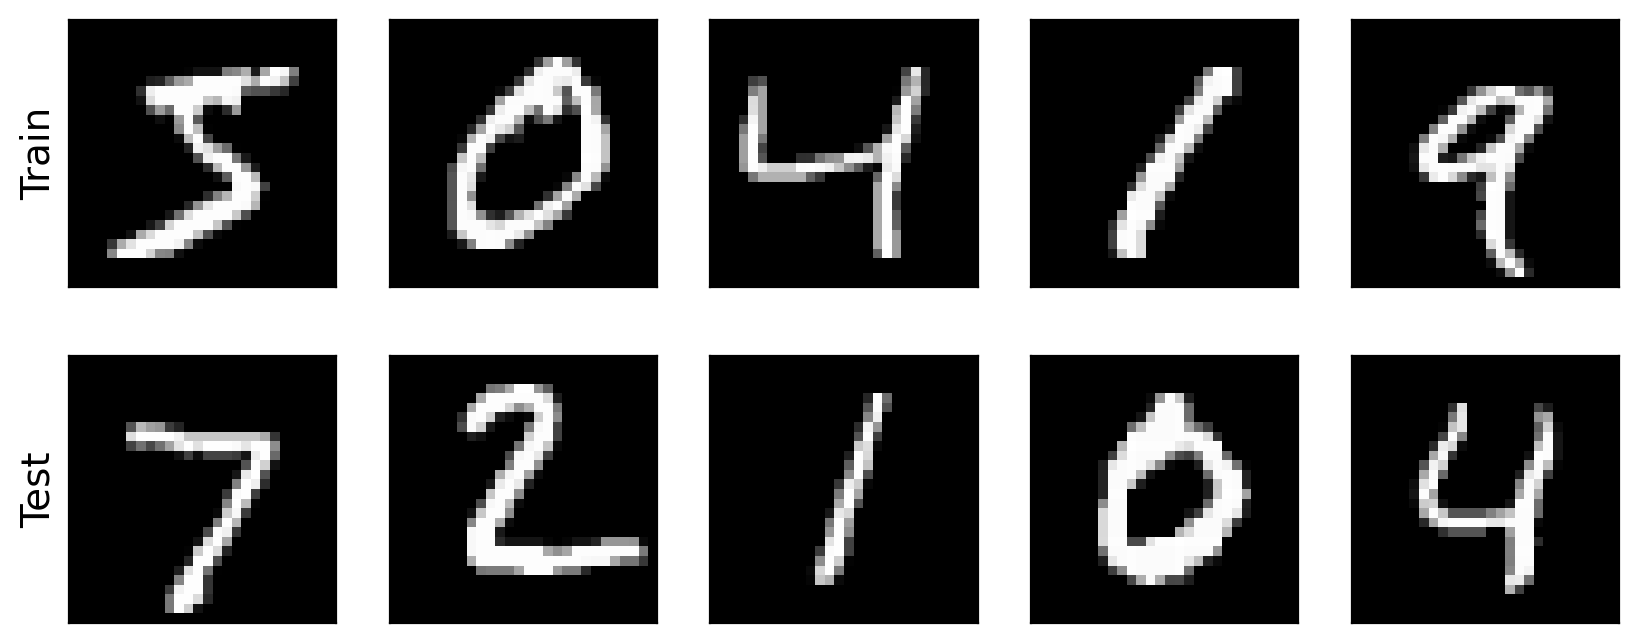

In [6]:
samples_train = train_dataset.data[:5]
samples_test = test_dataset.data[:5]
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, i+1)
    if i == 0:
        plt.ylabel('Train', fontsize=14)
    plt.imshow(samples_train[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(2, 5, i+6)
    if i == 0:
        plt.ylabel('Test', fontsize=14)
    plt.imshow(samples_test[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])


We need to build the dataloader: a function that cut the dataset in batches.

In [7]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

In [8]:
first_batch_images, first_batch_labels = next(iter(train_loader))
print('First batch:', first_batch_images.shape, first_batch_labels.shape)

First batch: torch.Size([100, 1, 28, 28]) torch.Size([100])


# 2 Wrapper for training and Evaluation

The goal of this section is to automatize the process of training and testing the model.

To do so, we will define a function that will take as input the model, the loss function, the optimizer, the number of epochs, and the train and test loaders. The function will return the loss of the model during the training and testing phases.


<font color='blue'>TODO:</font>
- Complete the AE_train function

In [9]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [10]:
# Set the device (cuda, cpu or mps) 
if torch.cuda.is_available(): 
    device = torch.device('cuda') 
elif torch.backends.mps.is_available() and torch.backends.mps.is_built(): 
    device = torch.device('mps') 
else: 
    device = torch.device('cpu') 
print("Device used: {}".format(device)) 
# type: ignore

Device used: mps


In [11]:
def AE_eval(model, criterion):
    '''AE_eval
    Evaluate the model on the test set
    Input:
        - model: the trained model
        - criterion: the loss function
    Output:
        - test_loss: the average loss on the test set
    '''
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images
            outputs = model(images)
            test_loss += criterion(outputs, images).item()
    return test_loss/len(test_loader)

def AE_train(model, criterion, optimizer, epochs=30, plot = True,verbose=False, freq=10):
    '''AE_train
    Train the model
    Input:
        - model: the model to train
        - criterion: the loss function
        - optimizer: the optimization algorithm
        - epochs: the number of epochs
        - plot: if True, plot the train and test losses
        - verbose: if True, print the losses
        - freq: frequency of printing the losses
    Output:
        - train_losses: the train losses
        - test_losses: the test losses
    '''
    if verbose:
        print('Start training...')
    train_losses=[]
    test_losses=[AE_eval(model, criterion)]
    for e in range(epochs):
        for batch_idx, (images, labels) in enumerate(train_loader):
            # Complete code here
            # Your code must include the following lines:
            # - Set the model to train mode
            model.train()
            # - Move the images to the device
            images = images.to(device)
            # - Reset the optimizer
            optimizer.zero_grad()
            # - Forward pass
            output = model(images)
            # - Compute the loss
            loss = criterion(output, images)
            # - Backward pass
            loss.backward()
            # - Update the weights
            optimizer.step()
            # - Print the losses if verbose is True
            if verbose:
                if batch_idx % freq == 0 or batch_idx == len(train_loader)-1:
                        print('Train Epoch: {} [{:5d}/{:5d} ({:3.0f}%)]\tLoss: {:.6f}'.format(
                                e, batch_idx * len(images), len(train_loader.dataset),
                                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            
        # - Evaluate the model at the end of each epoch    
        test_losses.append(AE_eval(model, criterion))

    if plot:
        plt.plot(train_losses, label='Train loss')
        plt.plot([e*batch_idx for e in range(e+2)], test_losses, label='Test loss', marker='o', linewidth=0.0)
        plt.legend()
        plt.xlabel('Batch')
        plt.ylabel('Loss')
        plt.show()
    return train_losses, test_losses



# 3 Linear Auto-encoder

The basic idea is to have a linear transformation for both the encoder and decoder.
For the output activation, we can use the sigmoid, since we know that the images are in greyscale, and the pixel values are between $0$ and $1$.

The only hyperparameter we have is the dimension of the latent space: $h_{\mathrm{dim}} < 784$.

## 3.1 First model


<font color='blue'>TODO:</font>
- Write a class for the encoder
- Test it on some images as sanity-check using the *plot_result* function



In [12]:
### Write the class
class AElin(nn.Module):
    '''AElin
    Autoencoder with linear layers
    Parameters:
        - hdim: the dimension of the hidden layer
    '''
    def __init__(self,hdim = 2):
        super().__init__()
        # Use the function nn.Sequential to define the encoder and decoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, hdim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(hdim, 28*28),
            nn.Sigmoid() 
        )

    def encoder_function(self, x):
        x = x.view(x.size(0), -1)
        return self.encoder(x)

    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.reshape(x.size(0), 1, 28, 28)
        return decoded



Number of parameters: 3922


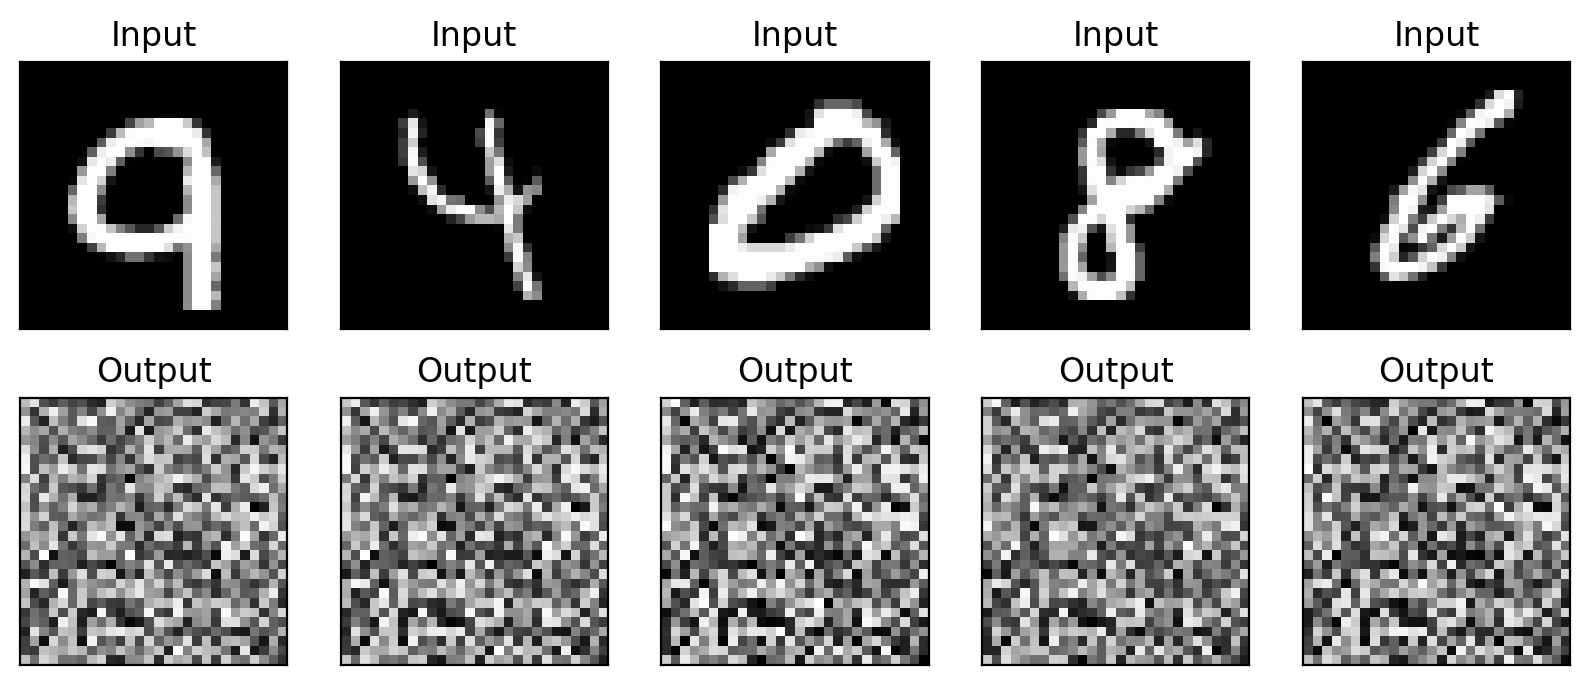

In [13]:
# Define the model and test it
model = AElin()
print_nparameters(model)
plot_result(model)

**TODO**
- Train your model and plot the loss during training for 5 epochs.
- Observe the result



In [15]:
# Model Initialization
# model = AElin()
print_nparameters(model)

# Validation using MSE Loss function
lossAE = nn.MSELoss()

# Using an Adam Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

AE_train(model, lossAE, optimizer, epochs=10, plot=True, verbose=True, freq=100)
plot_result(model)
plotLatentScatter(model.encoder_function, classes=[0,1,2,3,4,5,6,7,8,9])
plotLatentScatter(model.encoder_function, classes=[0,1])

Number of parameters: 3922
Start training...


RuntimeError: Tensor for argument weight is on cpu but expected on mps

## 3.2 Try different hyperpameters

<font color='blue'>TODO:</font>
- Try different latent dimension: 2, 10, 20 50, 100
- Try different learning rates: 1e-1, 1e-2, 1e-3, 1e-4, 1e-5

For each try, plot the reconstructions result and the losses.

Number of parameters: 3922
Start training...
Train Epoch: 0 [    0/60000 (  0%)]	Loss: 0.241177
Train Epoch: 0 [10000/60000 ( 17%)]	Loss: 0.237950
Train Epoch: 0 [20000/60000 ( 33%)]	Loss: 0.235766
Train Epoch: 0 [30000/60000 ( 50%)]	Loss: 0.231928
Train Epoch: 0 [40000/60000 ( 67%)]	Loss: 0.227409
Train Epoch: 0 [50000/60000 ( 83%)]	Loss: 0.223470
Train Epoch: 0 [59900/60000 (100%)]	Loss: 0.217714
Train Epoch: 1 [    0/60000 (  0%)]	Loss: 0.217936
Train Epoch: 1 [10000/60000 ( 17%)]	Loss: 0.211958
Train Epoch: 1 [20000/60000 ( 33%)]	Loss: 0.206175
Train Epoch: 1 [30000/60000 ( 50%)]	Loss: 0.200775
Train Epoch: 1 [40000/60000 ( 67%)]	Loss: 0.195028
Train Epoch: 1 [50000/60000 ( 83%)]	Loss: 0.189053
Train Epoch: 1 [59900/60000 (100%)]	Loss: 0.183244
Train Epoch: 2 [    0/60000 (  0%)]	Loss: 0.183253
Train Epoch: 2 [10000/60000 ( 17%)]	Loss: 0.178097
Train Epoch: 2 [20000/60000 ( 33%)]	Loss: 0.170463
Train Epoch: 2 [30000/60000 ( 50%)]	Loss: 0.166687
Train Epoch: 2 [40000/60000 ( 67%)]	L

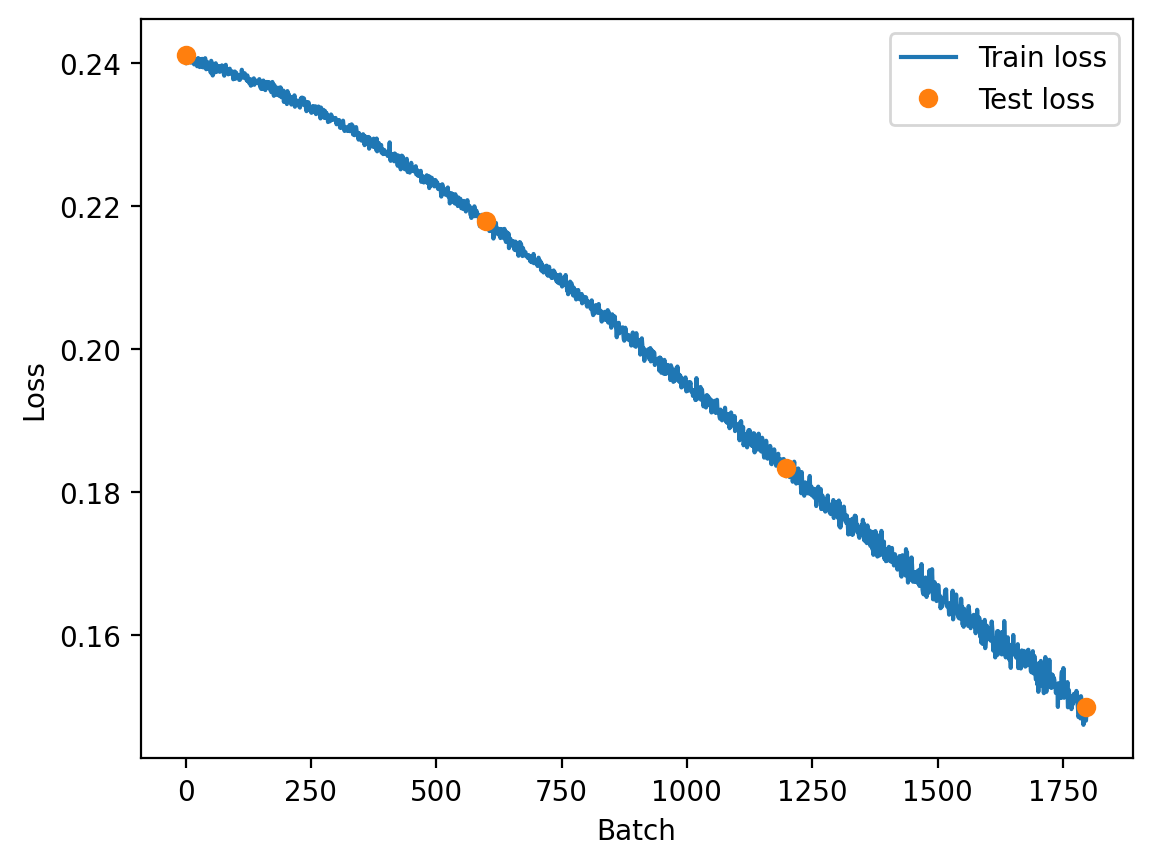

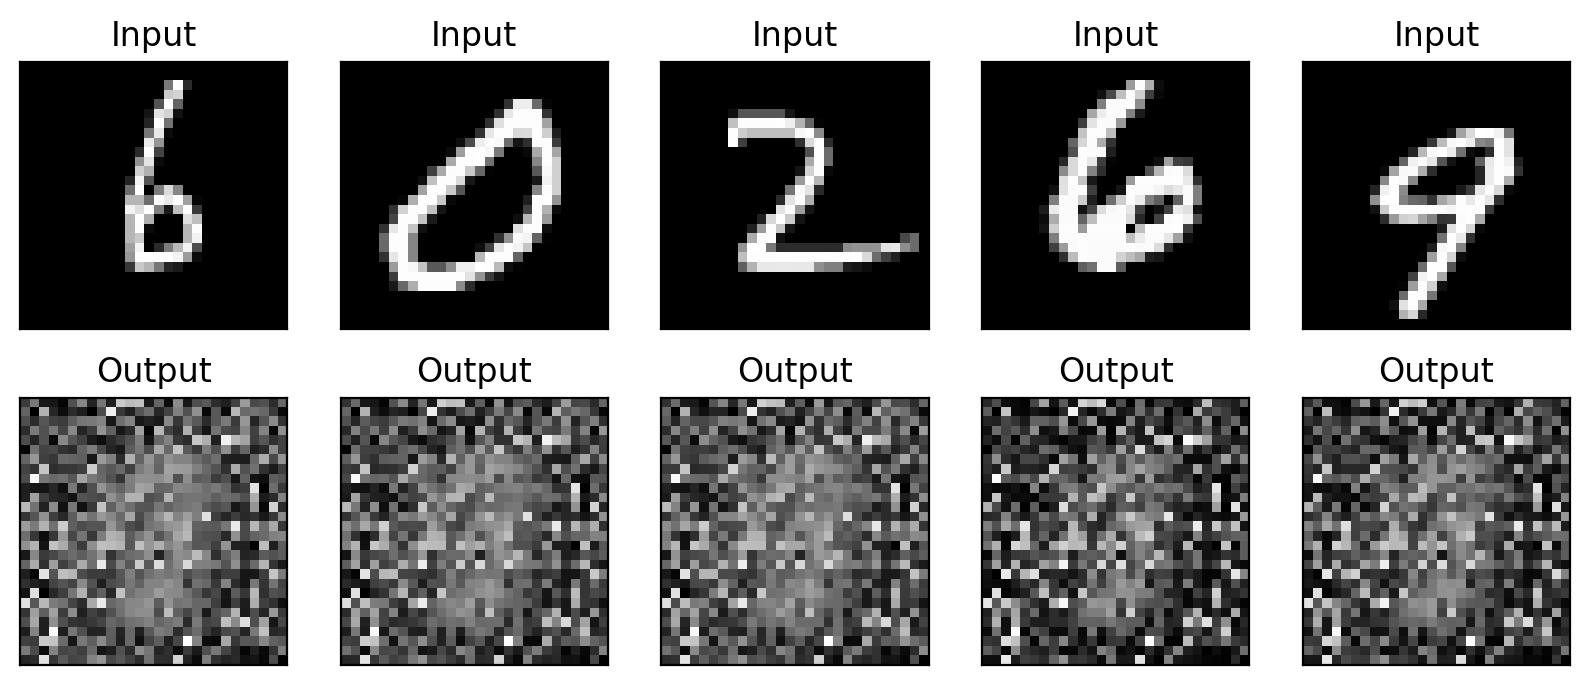

Number of parameters: 16474
Start training...
Train Epoch: 0 [    0/60000 (  0%)]	Loss: 0.233383
Train Epoch: 0 [10000/60000 ( 17%)]	Loss: 0.218894
Train Epoch: 0 [20000/60000 ( 33%)]	Loss: 0.192807
Train Epoch: 0 [30000/60000 ( 50%)]	Loss: 0.161261
Train Epoch: 0 [40000/60000 ( 67%)]	Loss: 0.133259
Train Epoch: 0 [50000/60000 ( 83%)]	Loss: 0.111266
Train Epoch: 0 [59900/60000 (100%)]	Loss: 0.094361
Train Epoch: 1 [    0/60000 (  0%)]	Loss: 0.093889
Train Epoch: 1 [10000/60000 ( 17%)]	Loss: 0.083392
Train Epoch: 1 [20000/60000 ( 33%)]	Loss: 0.076249
Train Epoch: 1 [30000/60000 ( 50%)]	Loss: 0.077297
Train Epoch: 1 [40000/60000 ( 67%)]	Loss: 0.073818
Train Epoch: 1 [50000/60000 ( 83%)]	Loss: 0.071872
Train Epoch: 1 [59900/60000 (100%)]	Loss: 0.072231
Train Epoch: 2 [    0/60000 (  0%)]	Loss: 0.067273
Train Epoch: 2 [10000/60000 ( 17%)]	Loss: 0.071346
Train Epoch: 2 [20000/60000 ( 33%)]	Loss: 0.070618
Train Epoch: 2 [30000/60000 ( 50%)]	Loss: 0.068992
Train Epoch: 2 [40000/60000 ( 67%)]	

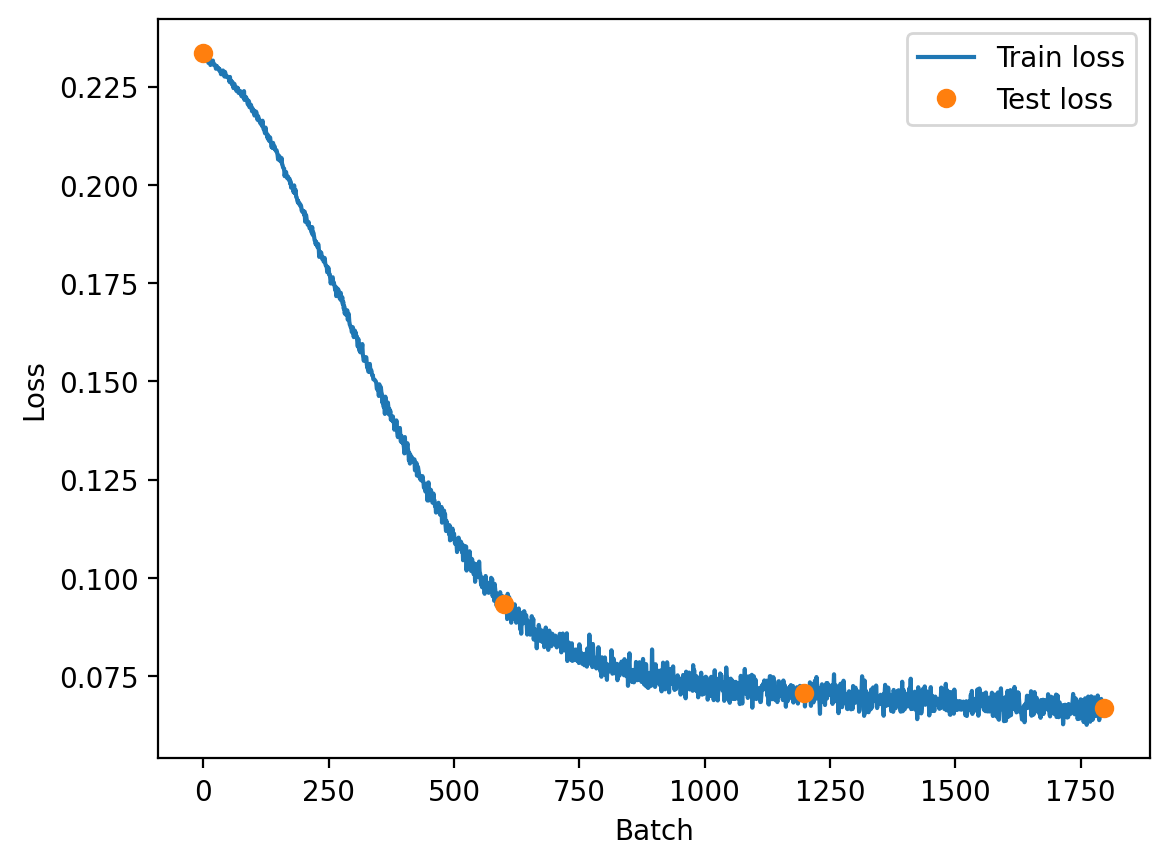

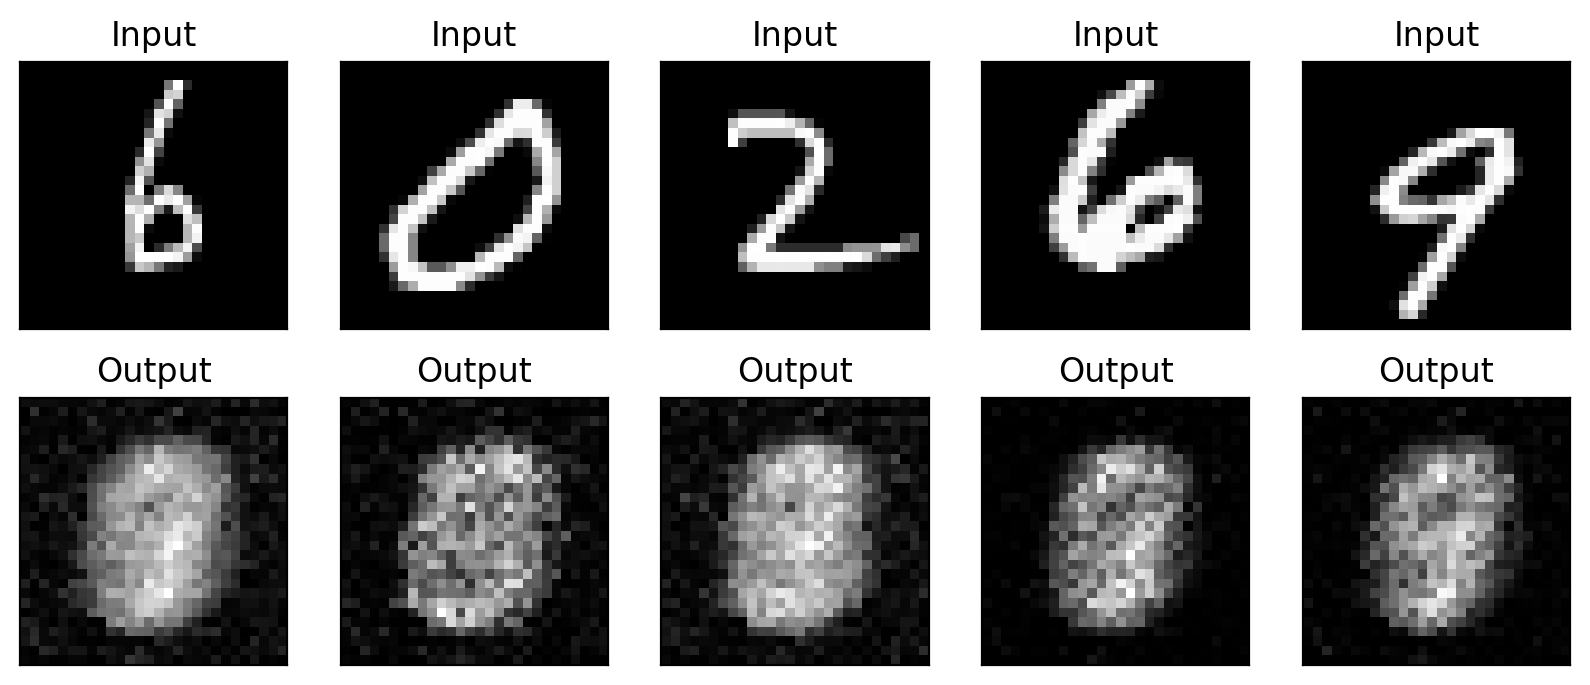

Number of parameters: 32164
Start training...
Train Epoch: 0 [    0/60000 (  0%)]	Loss: 0.232444
Train Epoch: 0 [10000/60000 ( 17%)]	Loss: 0.196942
Train Epoch: 0 [20000/60000 ( 33%)]	Loss: 0.142652
Train Epoch: 0 [30000/60000 ( 50%)]	Loss: 0.105531
Train Epoch: 0 [40000/60000 ( 67%)]	Loss: 0.088584
Train Epoch: 0 [50000/60000 ( 83%)]	Loss: 0.074953
Train Epoch: 0 [59900/60000 (100%)]	Loss: 0.070493
Train Epoch: 1 [    0/60000 (  0%)]	Loss: 0.071786
Train Epoch: 1 [10000/60000 ( 17%)]	Loss: 0.068138
Train Epoch: 1 [20000/60000 ( 33%)]	Loss: 0.072530
Train Epoch: 1 [30000/60000 ( 50%)]	Loss: 0.074438
Train Epoch: 1 [40000/60000 ( 67%)]	Loss: 0.067816
Train Epoch: 1 [50000/60000 ( 83%)]	Loss: 0.063315
Train Epoch: 1 [59900/60000 (100%)]	Loss: 0.061450
Train Epoch: 2 [    0/60000 (  0%)]	Loss: 0.062828
Train Epoch: 2 [10000/60000 ( 17%)]	Loss: 0.061663
Train Epoch: 2 [20000/60000 ( 33%)]	Loss: 0.060525
Train Epoch: 2 [30000/60000 ( 50%)]	Loss: 0.060578
Train Epoch: 2 [40000/60000 ( 67%)]	

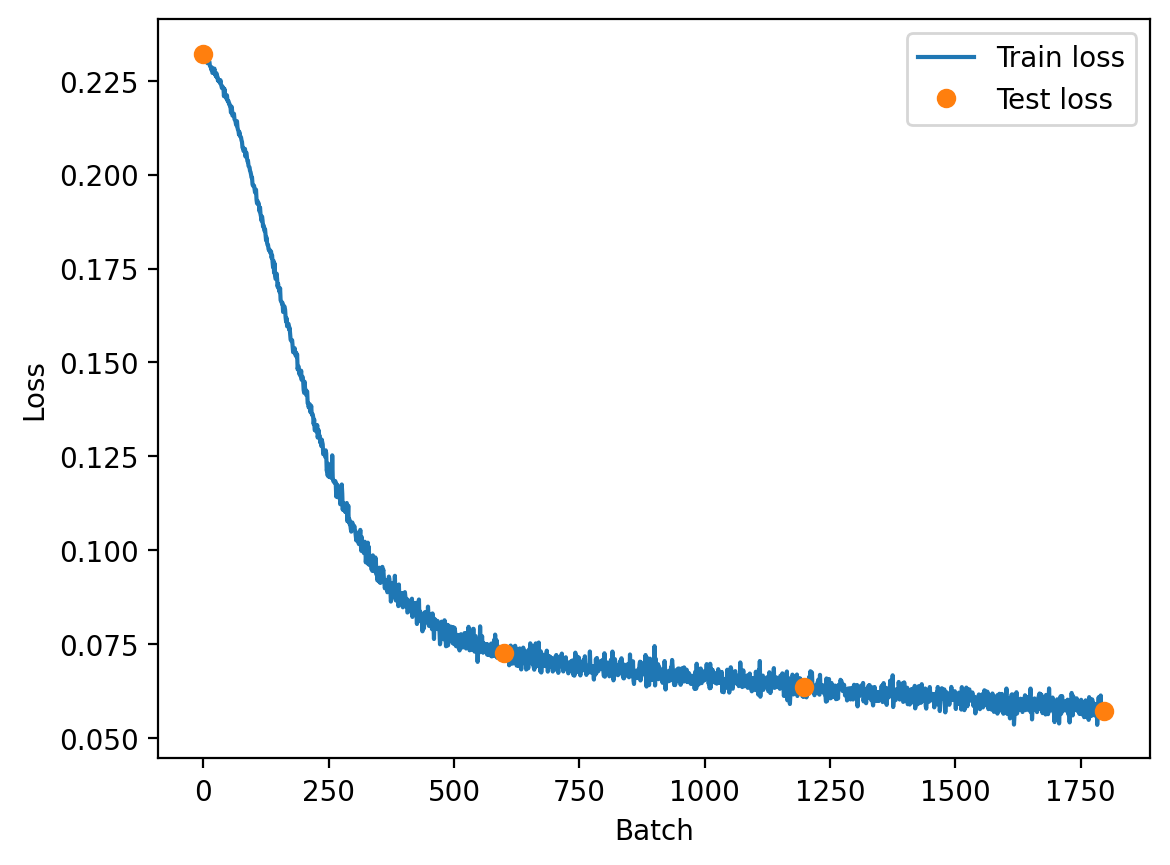

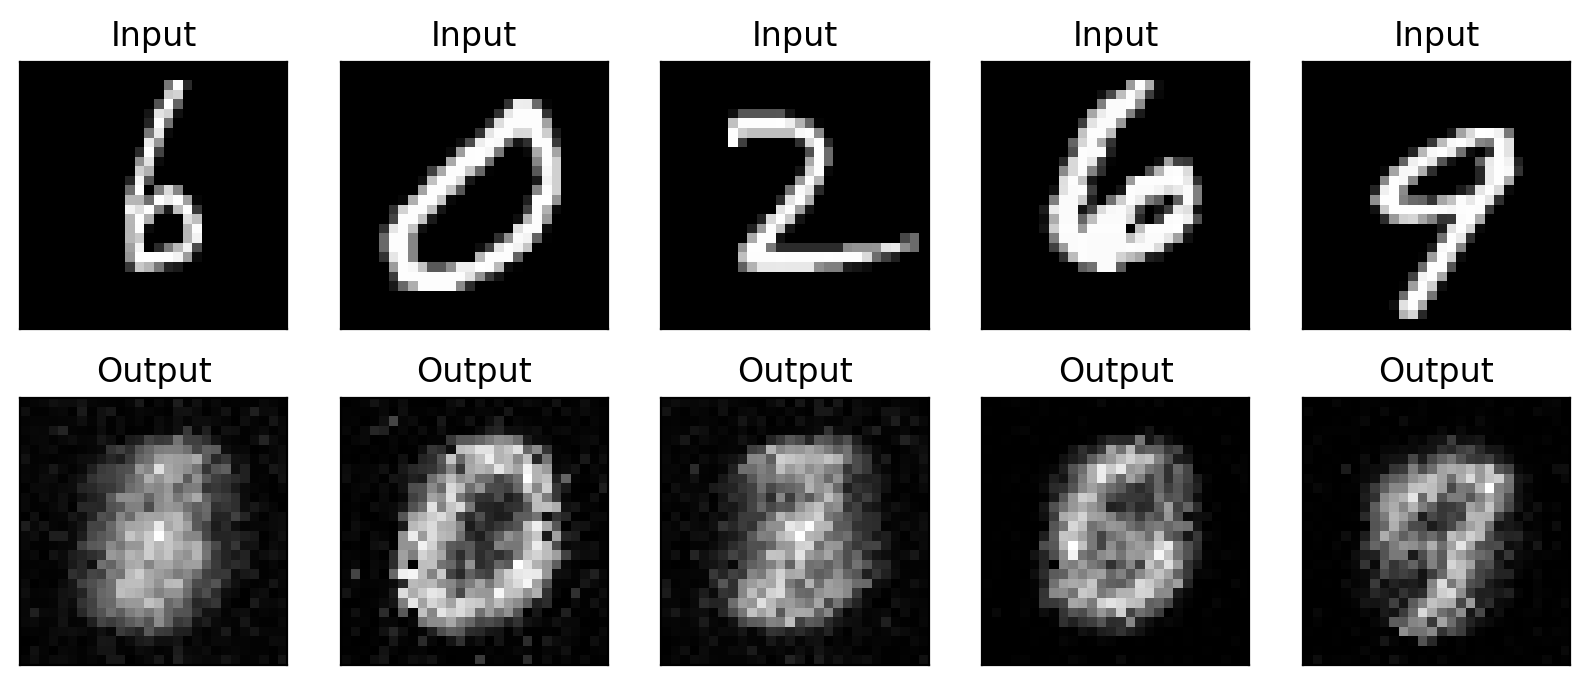

Number of parameters: 79234
Start training...
Train Epoch: 0 [    0/60000 (  0%)]	Loss: 0.232636
Train Epoch: 0 [10000/60000 ( 17%)]	Loss: 0.155438
Train Epoch: 0 [20000/60000 ( 33%)]	Loss: 0.089521
Train Epoch: 0 [30000/60000 ( 50%)]	Loss: 0.072513
Train Epoch: 0 [40000/60000 ( 67%)]	Loss: 0.073267
Train Epoch: 0 [50000/60000 ( 83%)]	Loss: 0.068723
Train Epoch: 0 [59900/60000 (100%)]	Loss: 0.063727
Train Epoch: 1 [    0/60000 (  0%)]	Loss: 0.066309
Train Epoch: 1 [10000/60000 ( 17%)]	Loss: 0.062104
Train Epoch: 1 [20000/60000 ( 33%)]	Loss: 0.059400
Train Epoch: 1 [30000/60000 ( 50%)]	Loss: 0.058089
Train Epoch: 1 [40000/60000 ( 67%)]	Loss: 0.054722
Train Epoch: 1 [50000/60000 ( 83%)]	Loss: 0.050538
Train Epoch: 1 [59900/60000 (100%)]	Loss: 0.053497
Train Epoch: 2 [    0/60000 (  0%)]	Loss: 0.049434
Train Epoch: 2 [10000/60000 ( 17%)]	Loss: 0.050283
Train Epoch: 2 [20000/60000 ( 33%)]	Loss: 0.046183
Train Epoch: 2 [30000/60000 ( 50%)]	Loss: 0.044849
Train Epoch: 2 [40000/60000 ( 67%)]	

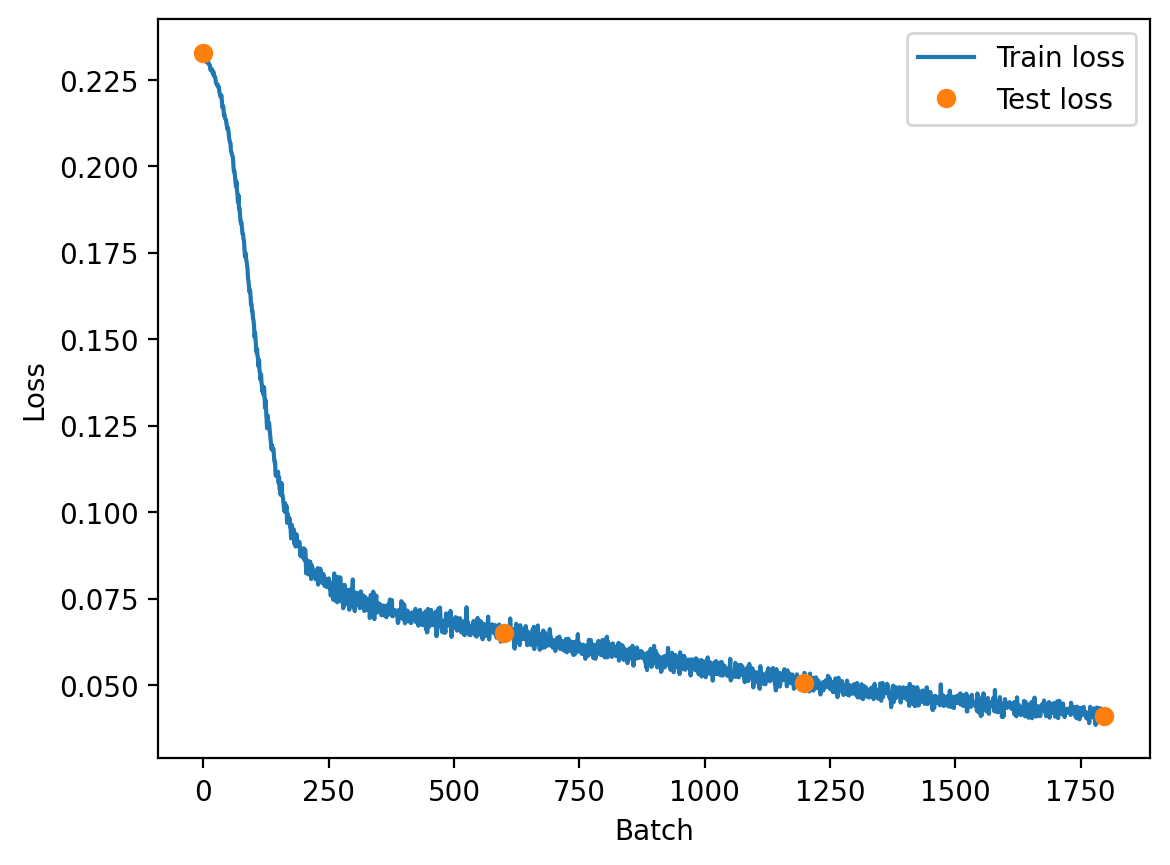

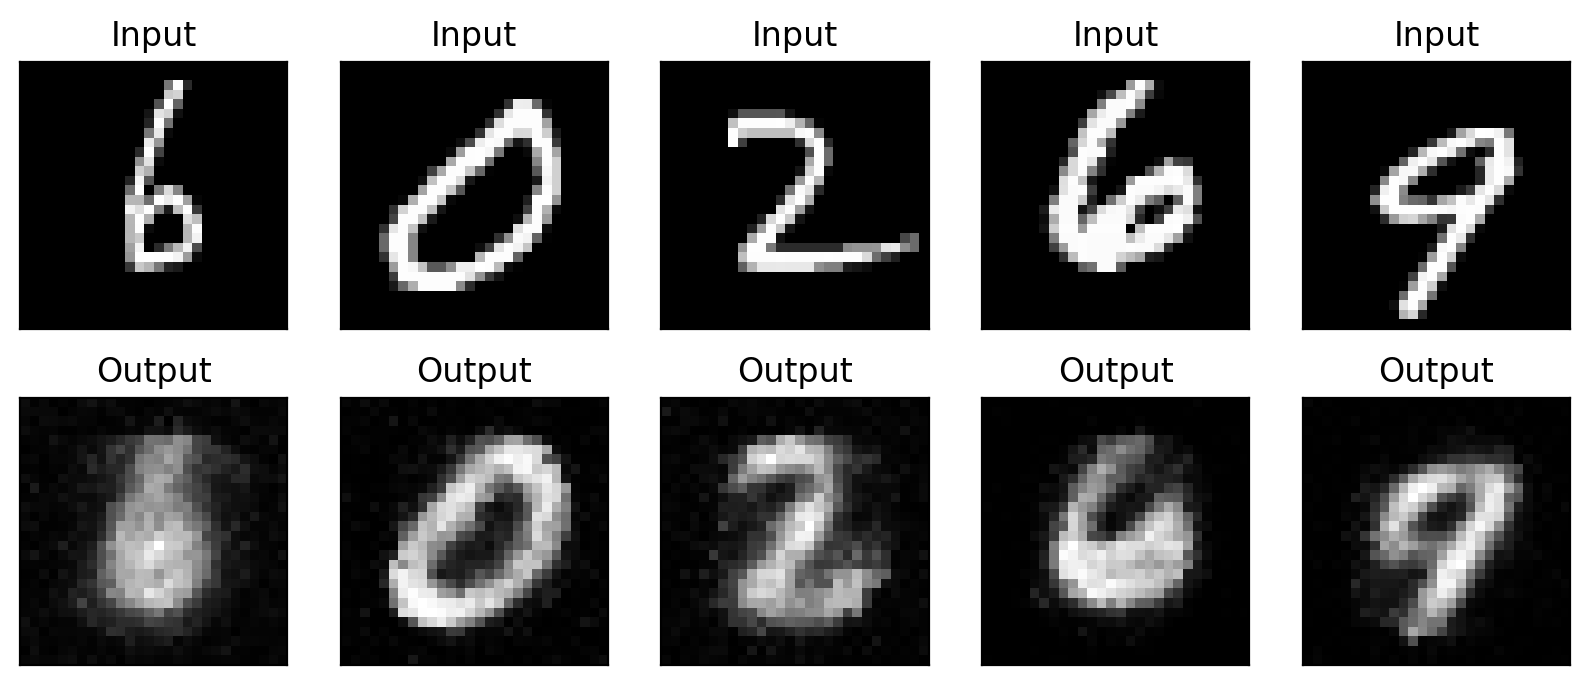

Number of parameters: 157684
Start training...
Train Epoch: 0 [    0/60000 (  0%)]	Loss: 0.232210
Train Epoch: 0 [10000/60000 ( 17%)]	Loss: 0.106265
Train Epoch: 0 [20000/60000 ( 33%)]	Loss: 0.074371
Train Epoch: 0 [30000/60000 ( 50%)]	Loss: 0.070393
Train Epoch: 0 [40000/60000 ( 67%)]	Loss: 0.064237
Train Epoch: 0 [50000/60000 ( 83%)]	Loss: 0.063052
Train Epoch: 0 [59900/60000 (100%)]	Loss: 0.056321
Train Epoch: 1 [    0/60000 (  0%)]	Loss: 0.057840
Train Epoch: 1 [10000/60000 ( 17%)]	Loss: 0.052303
Train Epoch: 1 [20000/60000 ( 33%)]	Loss: 0.049263
Train Epoch: 1 [30000/60000 ( 50%)]	Loss: 0.047772
Train Epoch: 1 [40000/60000 ( 67%)]	Loss: 0.048177
Train Epoch: 1 [50000/60000 ( 83%)]	Loss: 0.041918
Train Epoch: 1 [59900/60000 (100%)]	Loss: 0.040780
Train Epoch: 2 [    0/60000 (  0%)]	Loss: 0.039553
Train Epoch: 2 [10000/60000 ( 17%)]	Loss: 0.038652
Train Epoch: 2 [20000/60000 ( 33%)]	Loss: 0.038609
Train Epoch: 2 [30000/60000 ( 50%)]	Loss: 0.039346
Train Epoch: 2 [40000/60000 ( 67%)]

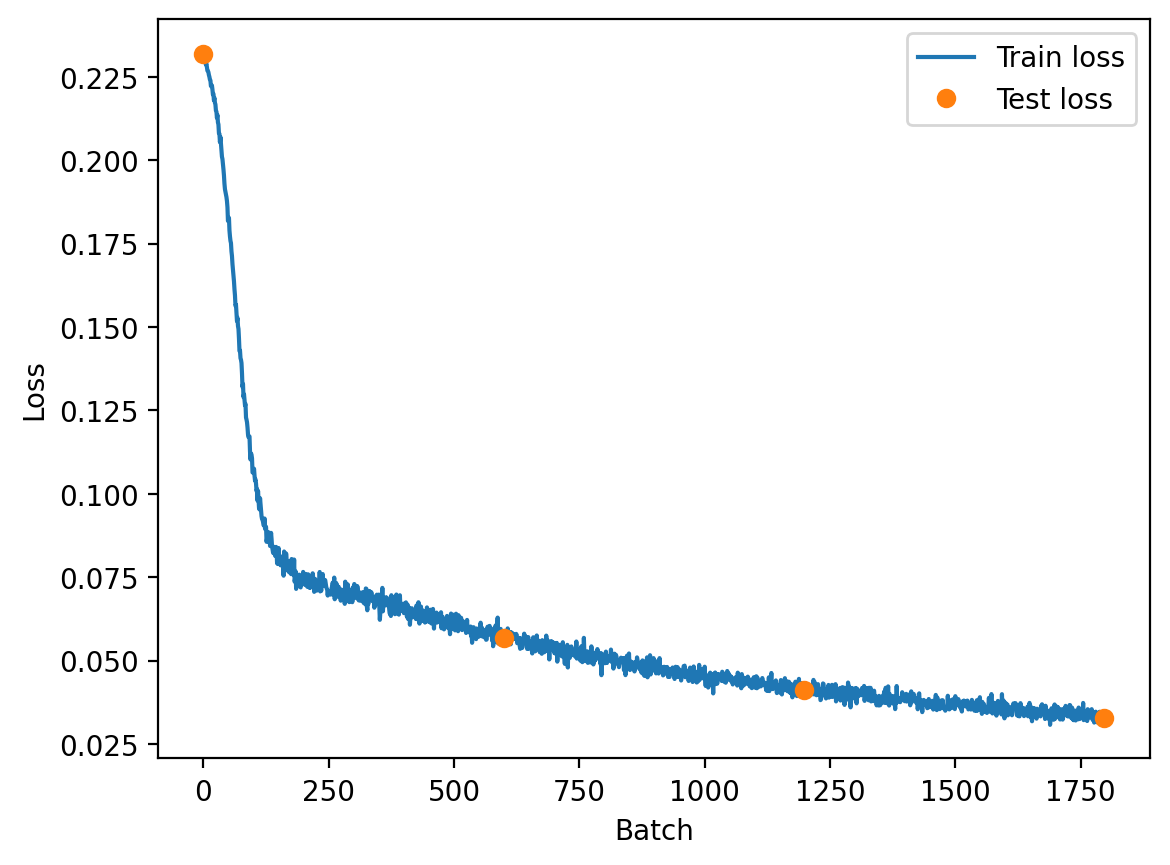

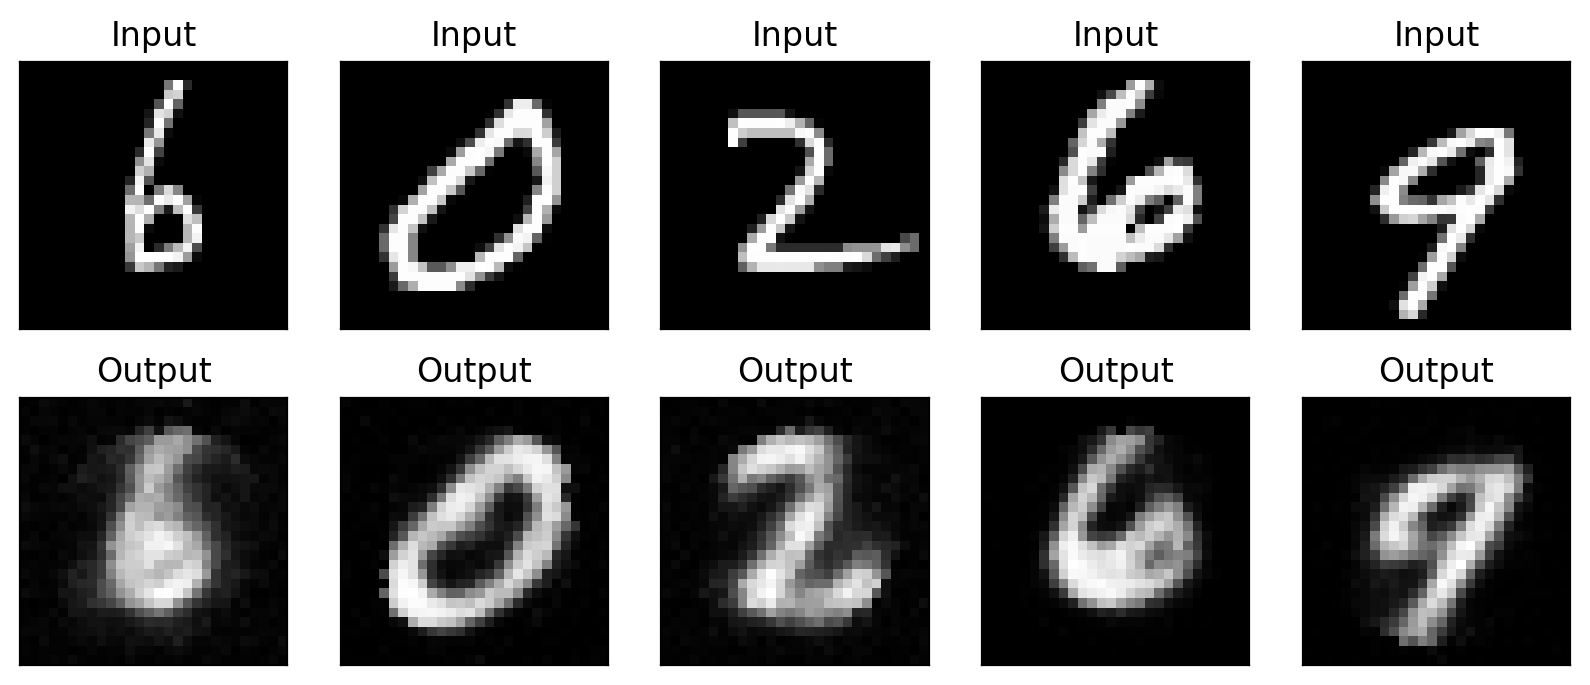

In [47]:
# Hidden dimension
for h in [2, 10, 20, 50, 100]:
    model = AElin(hdim=h)
    print_nparameters(model)

    # Validation using MSE Loss function
    lossAE = nn.MSELoss()

    # Using an Adam Optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    AE_train(model, lossAE, optimizer, epochs=3, plot=True, verbose=True, freq=100)
    plot_result(model)

Number of parameters: 3922
Start training...
Train Epoch: 0 [    0/60000 (  0%)]	Loss: 0.235824
Train Epoch: 0 [10000/60000 ( 17%)]	Loss: 0.063307
Train Epoch: 0 [20000/60000 ( 33%)]	Loss: 0.058728
Train Epoch: 0 [30000/60000 ( 50%)]	Loss: 0.059269
Train Epoch: 0 [40000/60000 ( 67%)]	Loss: 0.055009
Train Epoch: 0 [50000/60000 ( 83%)]	Loss: 0.056933
Train Epoch: 0 [59900/60000 (100%)]	Loss: 0.061410
Train Epoch: 1 [    0/60000 (  0%)]	Loss: 0.055580
Train Epoch: 1 [10000/60000 ( 17%)]	Loss: 0.060446
Train Epoch: 1 [20000/60000 ( 33%)]	Loss: 0.057348
Train Epoch: 1 [30000/60000 ( 50%)]	Loss: 0.056008
Train Epoch: 1 [40000/60000 ( 67%)]	Loss: 0.058041
Train Epoch: 1 [50000/60000 ( 83%)]	Loss: 0.057161
Train Epoch: 1 [59900/60000 (100%)]	Loss: 0.054317
Train Epoch: 2 [    0/60000 (  0%)]	Loss: 0.059291
Train Epoch: 2 [10000/60000 ( 17%)]	Loss: 0.058284
Train Epoch: 2 [20000/60000 ( 33%)]	Loss: 0.053592
Train Epoch: 2 [30000/60000 ( 50%)]	Loss: 0.055003
Train Epoch: 2 [40000/60000 ( 67%)]	L

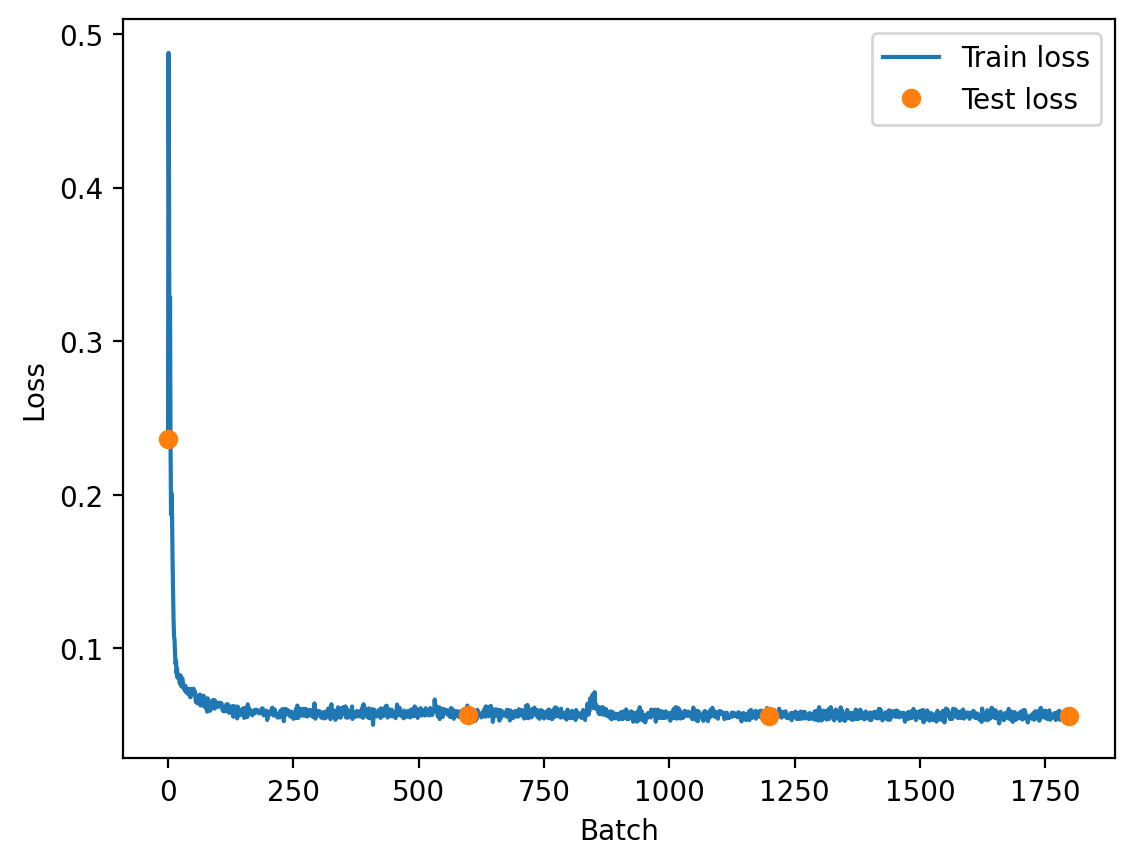

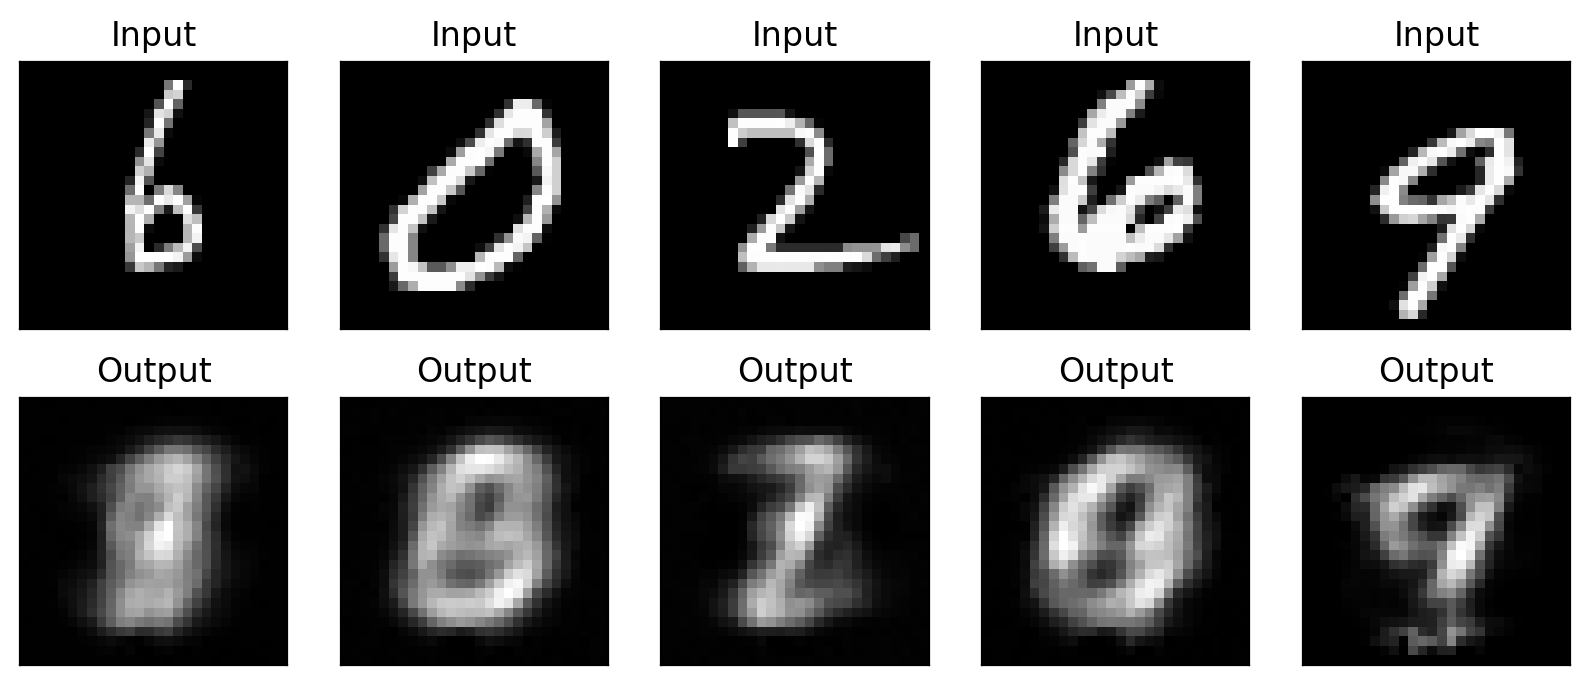

Number of parameters: 3922
Start training...
Train Epoch: 0 [    0/60000 (  0%)]	Loss: 0.246307
Train Epoch: 0 [10000/60000 ( 17%)]	Loss: 0.067886
Train Epoch: 0 [20000/60000 ( 33%)]	Loss: 0.065631
Train Epoch: 0 [30000/60000 ( 50%)]	Loss: 0.062969
Train Epoch: 0 [40000/60000 ( 67%)]	Loss: 0.056477
Train Epoch: 0 [50000/60000 ( 83%)]	Loss: 0.059924
Train Epoch: 0 [59900/60000 (100%)]	Loss: 0.056454
Train Epoch: 1 [    0/60000 (  0%)]	Loss: 0.060028
Train Epoch: 1 [10000/60000 ( 17%)]	Loss: 0.057426
Train Epoch: 1 [20000/60000 ( 33%)]	Loss: 0.060244
Train Epoch: 1 [30000/60000 ( 50%)]	Loss: 0.055506
Train Epoch: 1 [40000/60000 ( 67%)]	Loss: 0.058048
Train Epoch: 1 [50000/60000 ( 83%)]	Loss: 0.056068
Train Epoch: 1 [59900/60000 (100%)]	Loss: 0.054963
Train Epoch: 2 [    0/60000 (  0%)]	Loss: 0.054759
Train Epoch: 2 [10000/60000 ( 17%)]	Loss: 0.057426
Train Epoch: 2 [20000/60000 ( 33%)]	Loss: 0.056557
Train Epoch: 2 [30000/60000 ( 50%)]	Loss: 0.055774
Train Epoch: 2 [40000/60000 ( 67%)]	L

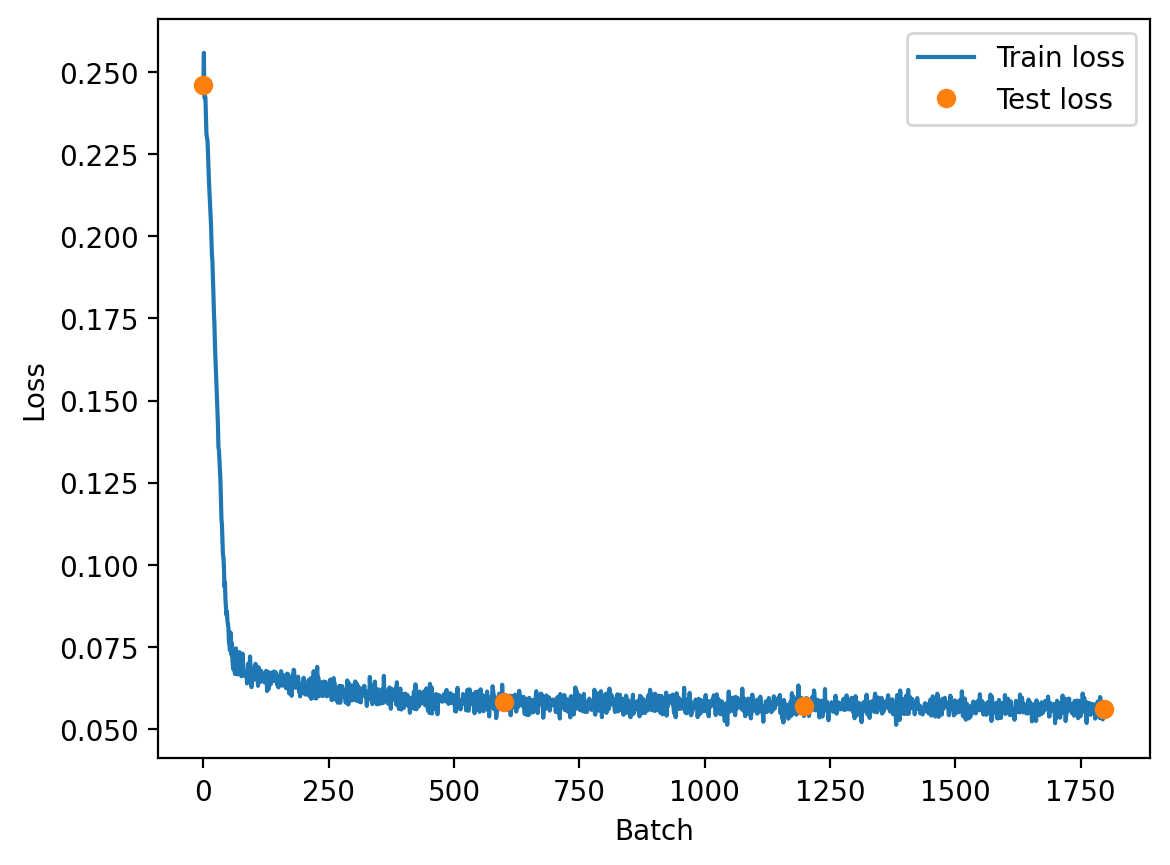

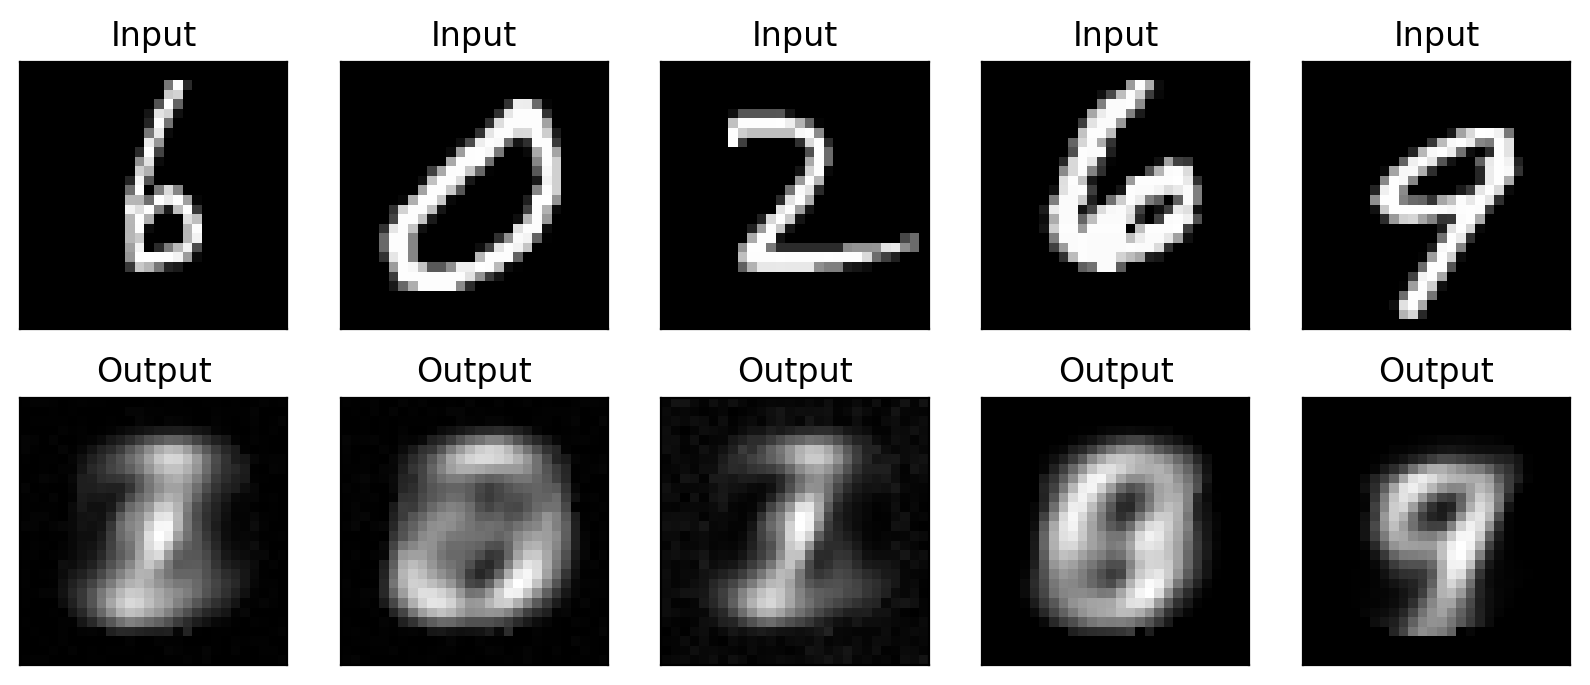

Number of parameters: 3922
Start training...
Train Epoch: 0 [    0/60000 (  0%)]	Loss: 0.240982
Train Epoch: 0 [10000/60000 ( 17%)]	Loss: 0.200256
Train Epoch: 0 [20000/60000 ( 33%)]	Loss: 0.141886
Train Epoch: 0 [30000/60000 ( 50%)]	Loss: 0.095689
Train Epoch: 0 [40000/60000 ( 67%)]	Loss: 0.071543
Train Epoch: 0 [50000/60000 ( 83%)]	Loss: 0.070333
Train Epoch: 0 [59900/60000 (100%)]	Loss: 0.067635
Train Epoch: 1 [    0/60000 (  0%)]	Loss: 0.067216
Train Epoch: 1 [10000/60000 ( 17%)]	Loss: 0.071009
Train Epoch: 1 [20000/60000 ( 33%)]	Loss: 0.067625
Train Epoch: 1 [30000/60000 ( 50%)]	Loss: 0.070891
Train Epoch: 1 [40000/60000 ( 67%)]	Loss: 0.066076
Train Epoch: 1 [50000/60000 ( 83%)]	Loss: 0.064467
Train Epoch: 1 [59900/60000 (100%)]	Loss: 0.067693
Train Epoch: 2 [    0/60000 (  0%)]	Loss: 0.065247
Train Epoch: 2 [10000/60000 ( 17%)]	Loss: 0.067611
Train Epoch: 2 [20000/60000 ( 33%)]	Loss: 0.067384
Train Epoch: 2 [30000/60000 ( 50%)]	Loss: 0.061651
Train Epoch: 2 [40000/60000 ( 67%)]	L

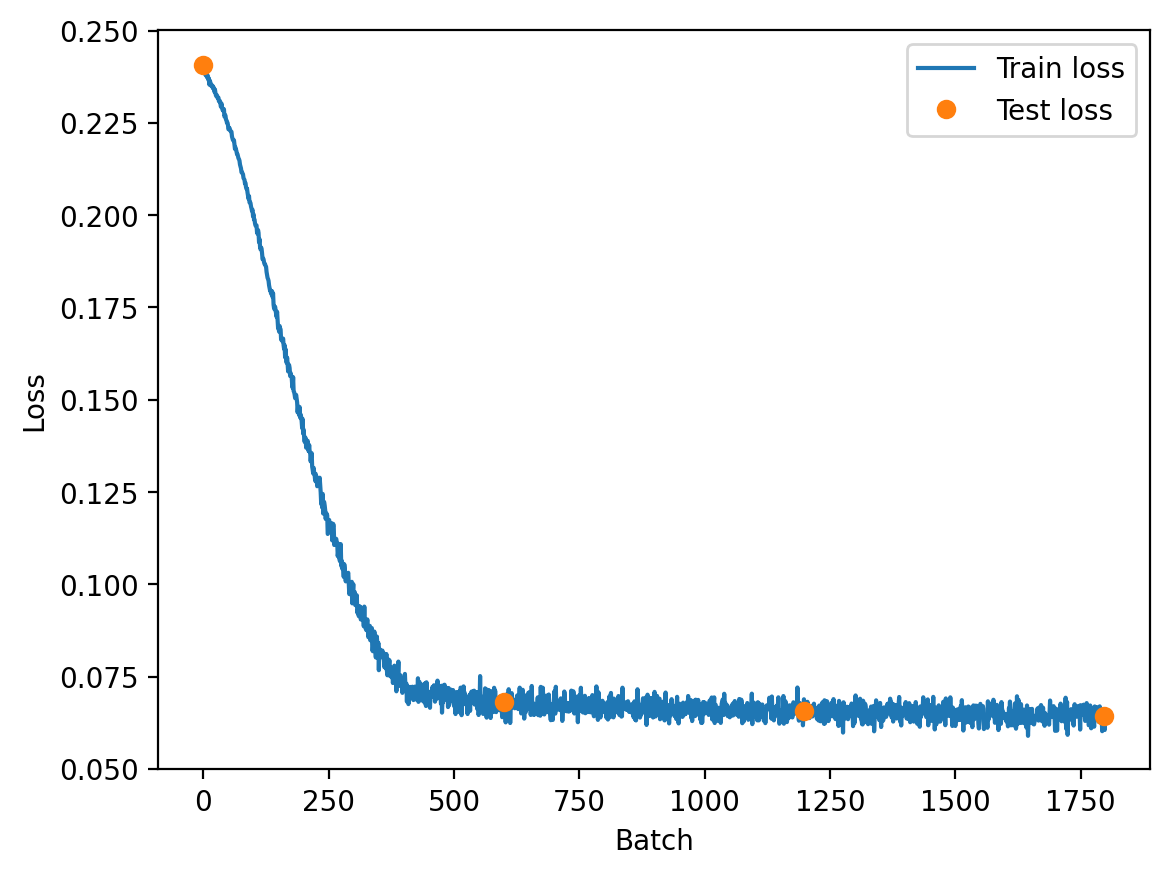

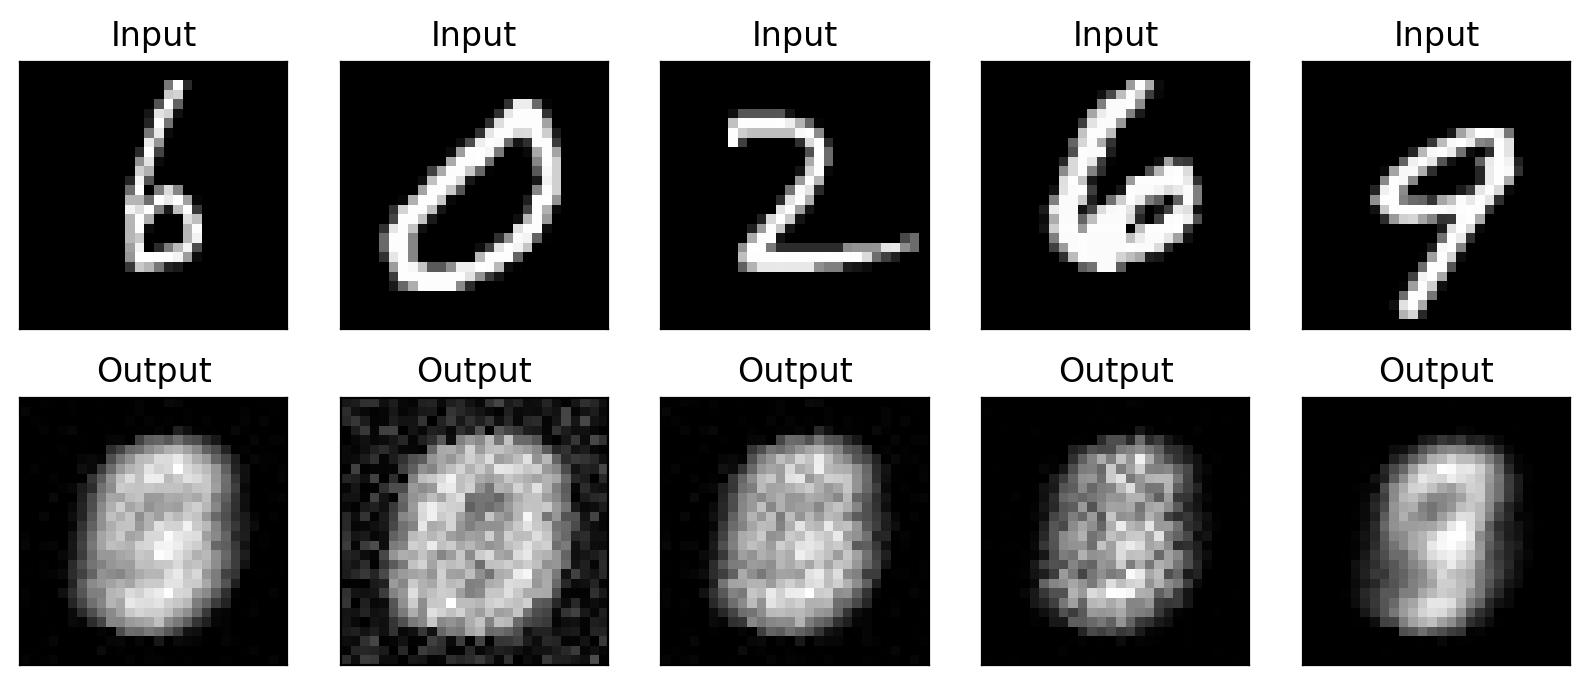

Number of parameters: 3922
Start training...
Train Epoch: 0 [    0/60000 (  0%)]	Loss: 0.238381
Train Epoch: 0 [10000/60000 ( 17%)]	Loss: 0.234988
Train Epoch: 0 [20000/60000 ( 33%)]	Loss: 0.232416
Train Epoch: 0 [30000/60000 ( 50%)]	Loss: 0.229195
Train Epoch: 0 [40000/60000 ( 67%)]	Loss: 0.224167
Train Epoch: 0 [50000/60000 ( 83%)]	Loss: 0.219947
Train Epoch: 0 [59900/60000 (100%)]	Loss: 0.215387
Train Epoch: 1 [    0/60000 (  0%)]	Loss: 0.214834
Train Epoch: 1 [10000/60000 ( 17%)]	Loss: 0.209131
Train Epoch: 1 [20000/60000 ( 33%)]	Loss: 0.203336
Train Epoch: 1 [30000/60000 ( 50%)]	Loss: 0.197803
Train Epoch: 1 [40000/60000 ( 67%)]	Loss: 0.191830
Train Epoch: 1 [50000/60000 ( 83%)]	Loss: 0.186531
Train Epoch: 1 [59900/60000 (100%)]	Loss: 0.181268
Train Epoch: 2 [    0/60000 (  0%)]	Loss: 0.181735
Train Epoch: 2 [10000/60000 ( 17%)]	Loss: 0.175477
Train Epoch: 2 [20000/60000 ( 33%)]	Loss: 0.170316
Train Epoch: 2 [30000/60000 ( 50%)]	Loss: 0.163722
Train Epoch: 2 [40000/60000 ( 67%)]	L

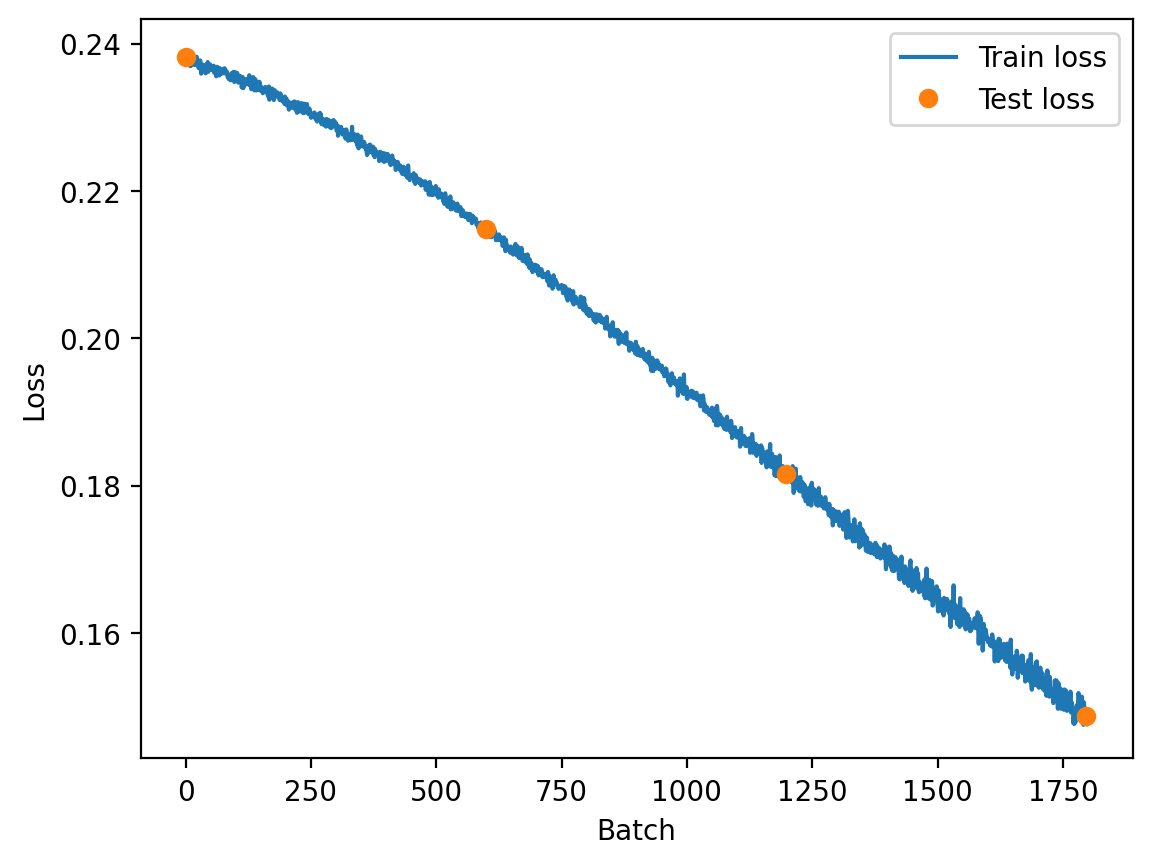

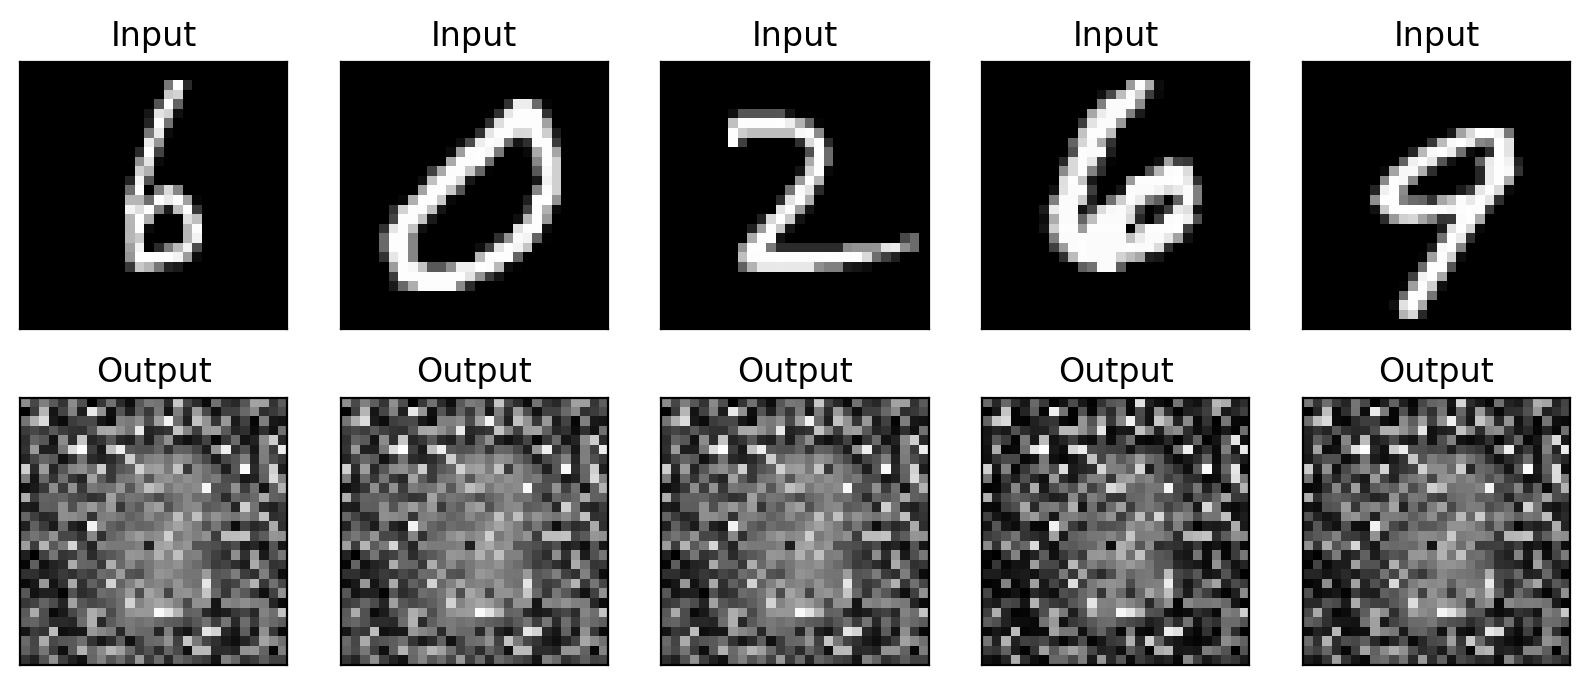

Number of parameters: 3922
Start training...
Train Epoch: 0 [    0/60000 (  0%)]	Loss: 0.243367
Train Epoch: 0 [10000/60000 ( 17%)]	Loss: 0.242593
Train Epoch: 0 [20000/60000 ( 33%)]	Loss: 0.241109
Train Epoch: 0 [30000/60000 ( 50%)]	Loss: 0.242202
Train Epoch: 0 [40000/60000 ( 67%)]	Loss: 0.241771
Train Epoch: 0 [50000/60000 ( 83%)]	Loss: 0.241422
Train Epoch: 0 [59900/60000 (100%)]	Loss: 0.240965
Train Epoch: 1 [    0/60000 (  0%)]	Loss: 0.240937
Train Epoch: 1 [10000/60000 ( 17%)]	Loss: 0.239921
Train Epoch: 1 [20000/60000 ( 33%)]	Loss: 0.240698
Train Epoch: 1 [30000/60000 ( 50%)]	Loss: 0.240049
Train Epoch: 1 [40000/60000 ( 67%)]	Loss: 0.240184
Train Epoch: 1 [50000/60000 ( 83%)]	Loss: 0.240315
Train Epoch: 1 [59900/60000 (100%)]	Loss: 0.240018
Train Epoch: 2 [    0/60000 (  0%)]	Loss: 0.241038
Train Epoch: 2 [10000/60000 ( 17%)]	Loss: 0.240718
Train Epoch: 2 [20000/60000 ( 33%)]	Loss: 0.238761
Train Epoch: 2 [30000/60000 ( 50%)]	Loss: 0.239005
Train Epoch: 2 [40000/60000 ( 67%)]	L

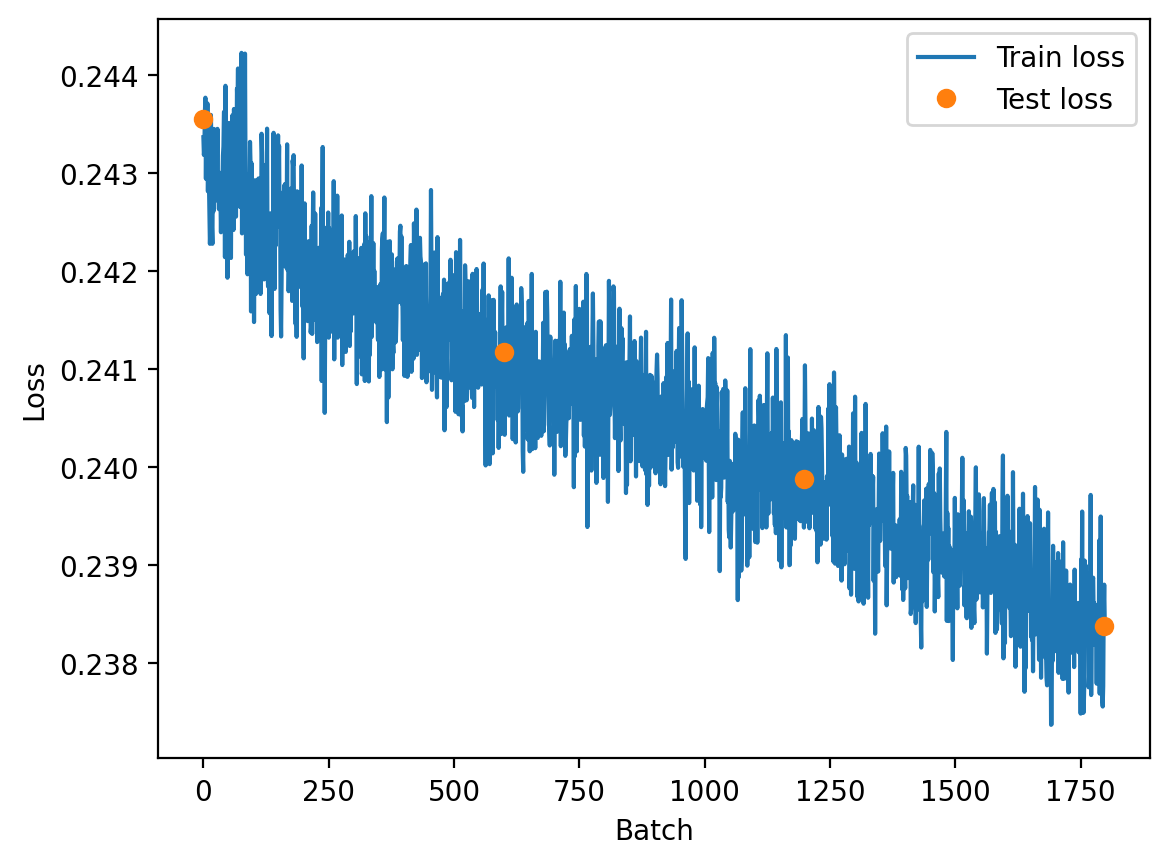

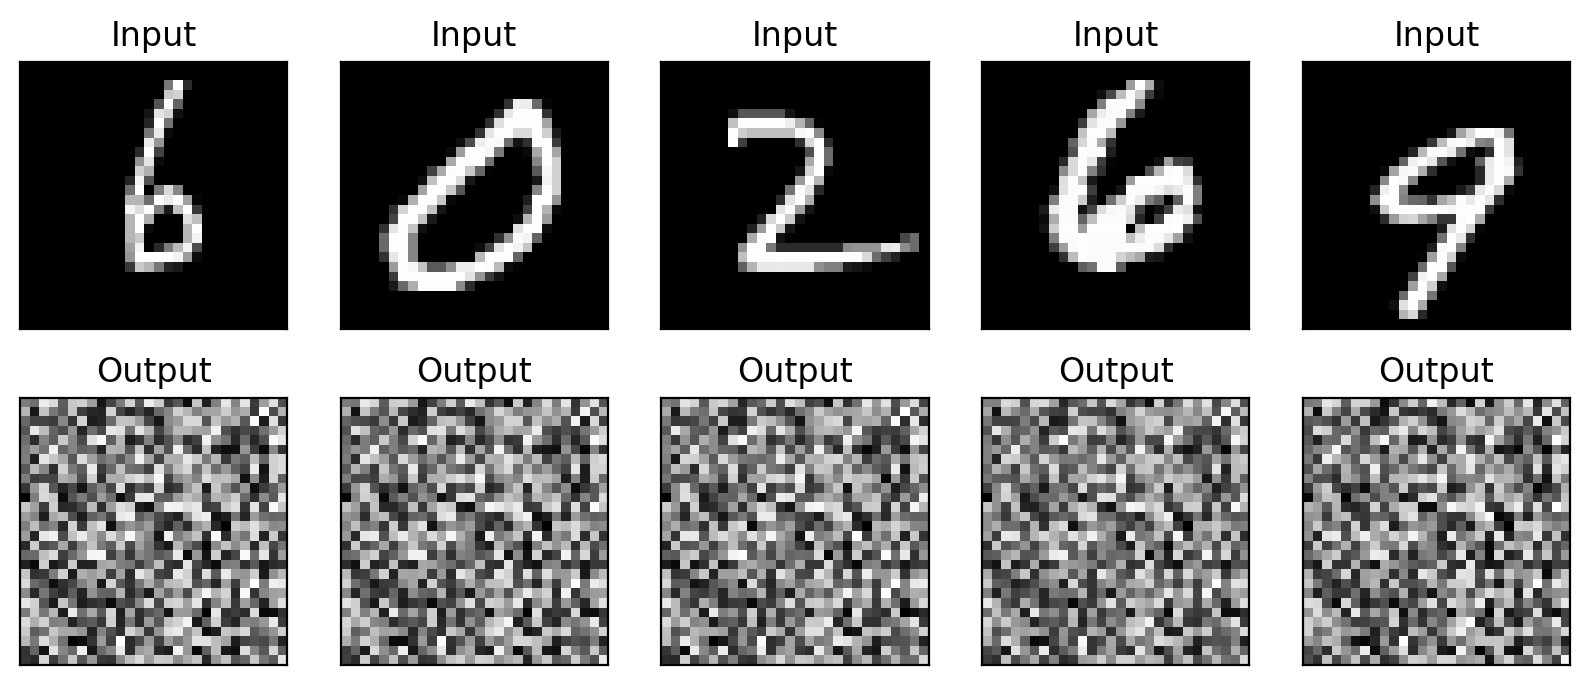

In [48]:
for lr in [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]:
    model = AElin()
    print_nparameters(model)

    # Validation using MSE Loss function
    lossAE = nn.MSELoss()

    # Using an Adam Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    AE_train(model, lossAE, optimizer, epochs=3, plot=True, verbose=True, freq=100)
    plot_result(model)

# 4 Use the AE as a denoising model

We will see in this section how we can use the a AutoEncoder a denoising model. First, we define a function that will add noise to the images and plot the reconstruction.

In [ ]:
def plot_denoising(model):
    images = first_batch_images[:1]
    sigmas = [1e-2,2e-2, 5e-2, 1e-1,3e-1, 5e-1]
    plt.figure(figsize=(8, 4))
    for k, sigma in enumerate(sigmas):

        plt.subplot(3,len(sigmas),  k+1)
        if k==0:
            plt.ylabel('Original', fontsize=14)
        plt.imshow(images.cpu().numpy().reshape(28, 28), cmap='gray')
        plt.xticks([])
        plt.yticks([])

        noise = torch.randn(1, 1, 28, 28) * sigma
        plt.subplot(3, len(sigmas), k+1+len(sigmas))
        if k == 0:
            plt.ylabel('Noisy', fontsize=14)
        plt.imshow((noise+images).cpu().numpy().reshape(28, 28), cmap='gray')
        plt.title(f'noise: {sigma:.0e}')
        plt.xticks([])
        plt.yticks([])

        plt.subplot(3, len(sigmas), k+1+2*len(sigmas))
        if k == 0:
            plt.ylabel('Reconstructed', fontsize=14)
        plt.imshow(model((images+noise)).cpu().detach().numpy().reshape(28, 28), cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

<font color='blue'>TODO:</font>
- Compare the performance of three different models with $h_{\mathrm{dim}}=10$, $h_{\mathrm{dim}}=100$ and $h_{\mathrm{dim}}=500$

In [ ]:
AE = ... # Complete code here
optimizer = ... # Complete code here
AE_train(AE, lossAE, optimizer, epochs=3, plot=False, verbose=False, freq=100);
plot_denoising(AE)



In [ ]:
AE = ... # Complete code here
optimizer = ... # Complete code here
AE_train(AE, lossAE, optimizer, epochs=3, plot=False, verbose=False, freq=100);
plot_denoising(AE)


In [ ]:
AE = ... # Complete code here
optimizer = ... # Complete code here
AE_train(AE, lossAE, optimizer, epochs=3, plot=False, verbose=False, freq=100)
plot_denoising(AE)


<font color='blue'>(BONUS) TODO:</font>
- Propose a new training procedure to train the model as a denoising model.

In [ ]:

def AE_train_denoising(model, criterion, optimizer, epochs=30, plot = True,verbose=False, freq=10):
    '''AE_train for denoising task
    Train the model
    Input:
        - model: the model to train
        - criterion: the loss function
        - optimizer: the optimization algorithm
        - epochs: the number of epochs
        - plot: if True, plot the train and test losses
        - verbose: if True, print the losses
        - freq: frequency of printing the losses
    Output:
        - train_losses: the train losses
        - test_losses: the test losses
    '''

    if verbose:
        print('Start training...')
    train_losses=[]
    test_losses=[AE_eval(model, criterion)]
    for e in range(epochs):
        for batch_idx, (images, labels) in enumerate(train_loader):
       ... # Complete code here
     if plot:
        plt.plot(train_losses, label='Train loss')
        plt.plot([e*batch_idx for e in range(e+2)], test_losses, label='Test loss', marker='o', linewidth=0.0)
        plt.legend()
        plt.xlabel('Batch')
        plt.ylabel('Loss')
        plt.show()
    return train_losses, test_losses


AE = AElin(hdim=100)
optimizer = optim.Adam(AE.parameters(), lr=1e-2)
AE_train_denoising(AE, lossAE, optimizer, epochs=3, plot=True, verbose=False, freq=100)
plot_result(AE)
plot_denoising(AE)


# 5 Anomaly detection

Autoencoders can learn to represent the data in a latent representation space and to reconstruct the data from this compressed representation. One possible application of AE is Anomaly detection. The method is simple:
- if you encode and decode an image similar to the training data, the reconstruction loss should be low, while
- if you do the same with an image that differs from the training set, the loss should be higher.

We will use a strong model:

Start training...
Train Epoch: 0 [    0/60000 (  0%)]	Loss: 0.231734
Train Epoch: 0 [ 1000/60000 (  2%)]	Loss: 0.137809
Train Epoch: 0 [ 2000/60000 (  3%)]	Loss: 0.077354
Train Epoch: 0 [ 3000/60000 (  5%)]	Loss: 0.067816
Train Epoch: 0 [ 4000/60000 (  7%)]	Loss: 0.064506
Train Epoch: 0 [ 5000/60000 (  8%)]	Loss: 0.063375
Train Epoch: 0 [ 6000/60000 ( 10%)]	Loss: 0.062468
Train Epoch: 0 [ 7000/60000 ( 12%)]	Loss: 0.058116
Train Epoch: 0 [ 8000/60000 ( 13%)]	Loss: 0.053889
Train Epoch: 0 [ 9000/60000 ( 15%)]	Loss: 0.056868
Train Epoch: 0 [10000/60000 ( 17%)]	Loss: 0.048834
Train Epoch: 0 [11000/60000 ( 18%)]	Loss: 0.046350
Train Epoch: 0 [12000/60000 ( 20%)]	Loss: 0.044636
Train Epoch: 0 [13000/60000 ( 22%)]	Loss: 0.044905
Train Epoch: 0 [14000/60000 ( 23%)]	Loss: 0.040341
Train Epoch: 0 [15000/60000 ( 25%)]	Loss: 0.039100
Train Epoch: 0 [16000/60000 ( 27%)]	Loss: 0.038165
Train Epoch: 0 [17000/60000 ( 28%)]	Loss: 0.037351
Train Epoch: 0 [18000/60000 ( 30%)]	Loss: 0.035893
Train Epoch: 

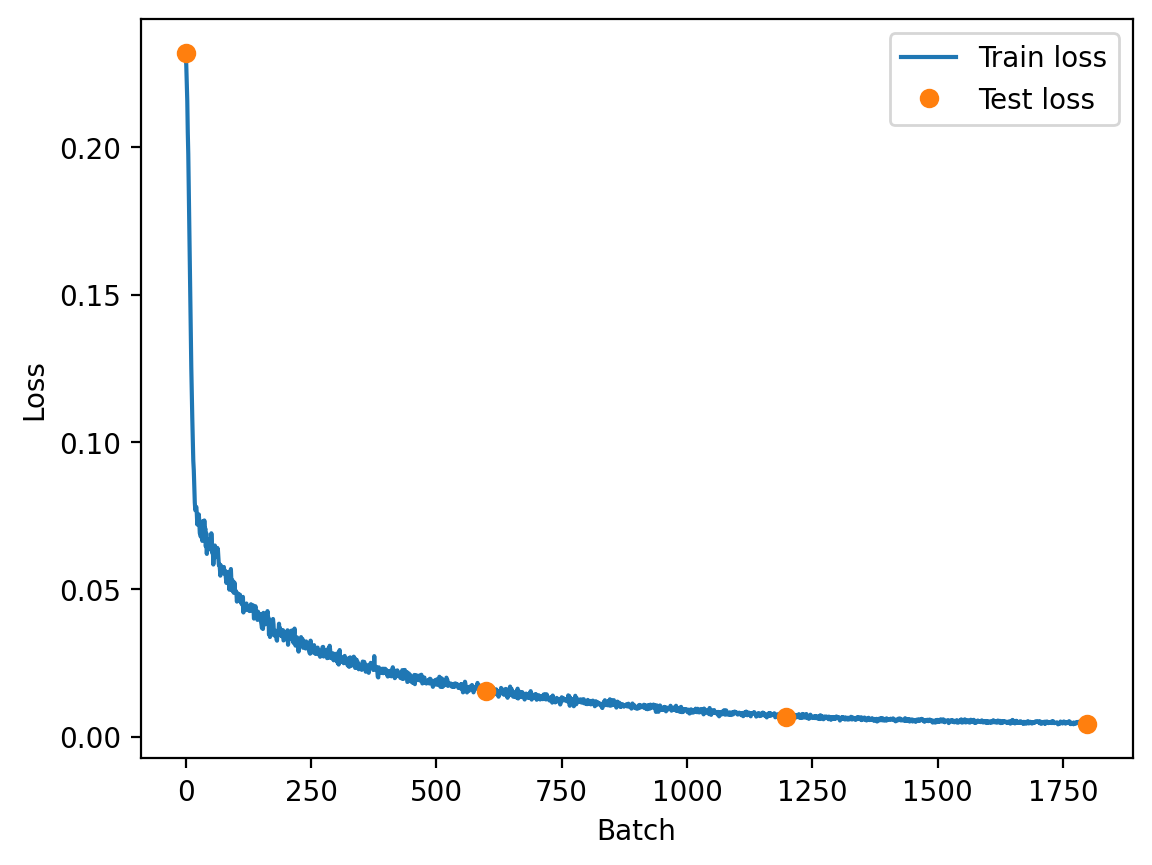

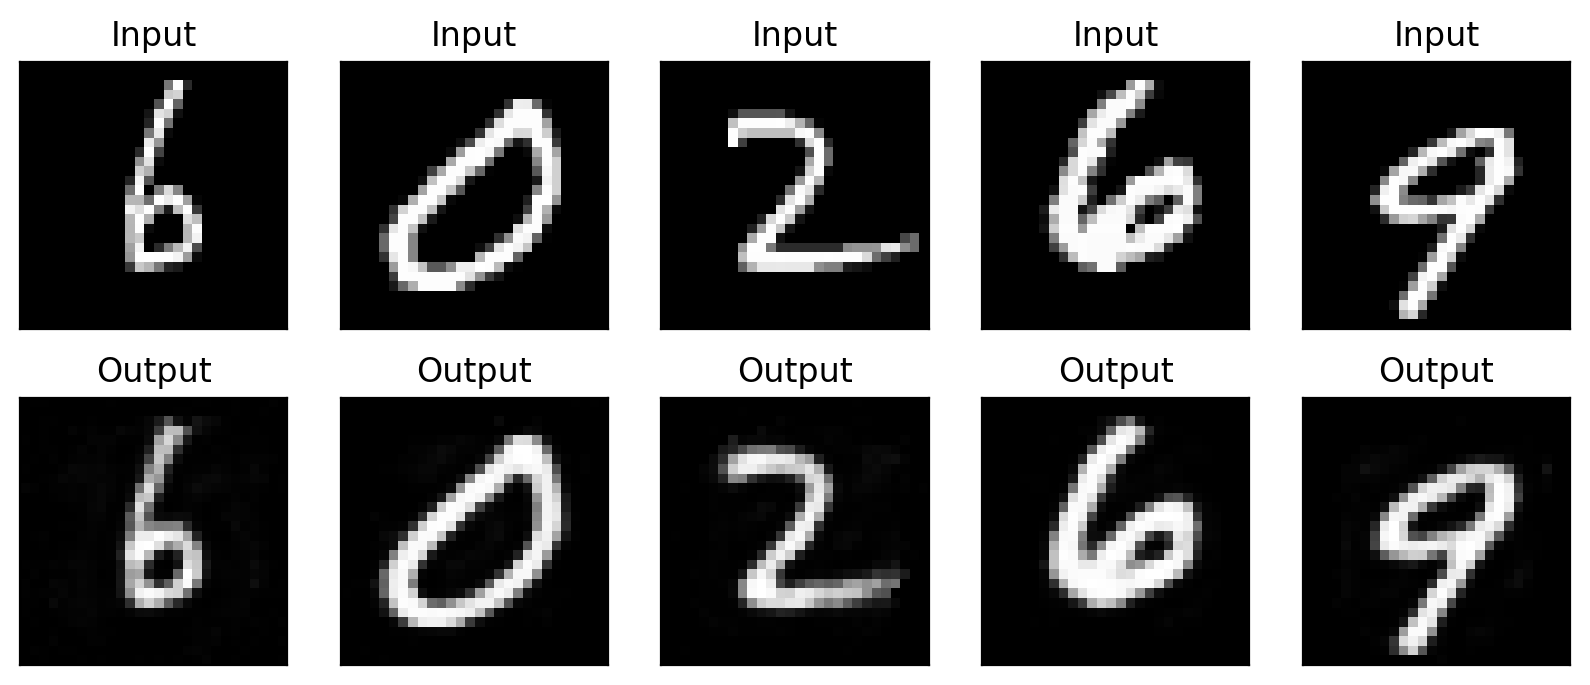

In [50]:
AE = AElin(hdim=100) # Complete code here
optimizer = optim.Adam(AE.parameters(), lr=1e-3) # Complete code here
AE_train(AE, lossAE, optimizer, epochs=3, plot=True, verbose=True, freq=10); # Complete code here
plot_result(AE)


To test compare data dstribution we can compare:
- the loss on the training data
- the loss on the training with different anomalies
    - Transpositions
    - Artifacts
    - Mixing

In [51]:
def make_anomaly(input_data, mode='transpose'):
    '''make_anomaly
    Detect anomalies in the input data using the model
    Input:
        - input_data: the input data
        - mode: the mode for the anomaly detection among ['transpose', 'artifacts', 'mixing']
    Output:
        - anomalies: the pertubed images
    '''
    if mode == 'transpose':
        anomalies = input_data.clone()
        anomalies = anomalies.permute(0, 1, 3, 2)

    elif mode == 'artifacts':
        anomalies = input_data.clone()
        anomalies[:, :, 10:20, 10:20] = 1
    elif mode == 'mixing':
        anomalies = input_data.clone()
        anomalies[:, :, 10:15, 10:15] = input_data[:, :, 15:20, 15:20]
        anomalies[:, :, 15:20, 15:20] = input_data[:, :, 10:15, 10:15]
        anomalies[:, :, 10:15, 15:20] = input_data[:, :, 15:20, 10:15]
        anomalies[:, :, 15:20, 10:15] = input_data[:, :, 10:15, 15:20]
    return anomalies

def plot_anomalies(model, mode='transpose'):
    anomalies = make_anomaly(first_batch_images, mode=mode)
    recons = model(first_batch_images)
    recons_a = model(anomalies)

    plt.figure(figsize=(8, 5))
    for i in range(5):
        plt.subplot(4, 5, i+1)
        image = first_batch_images[i].cpu().numpy().reshape(28, 28)
        if i == 0:
            plt.ylabel('Original', fontsize=14)
        plt.imshow(image, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.subplot(4, 5, i+6)
        recon = recons[i].cpu().detach().numpy().reshape(28, 28)
        if i == 0:
            plt.ylabel('Recons', fontsize=14)
        plt.title(f'MSE: {np.linalg.norm(image - recon):.2f}', fontsize=14)
        plt.imshow(recon, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.subplot(4, 5, i+11)
        anomaly = anomalies[i].detach().numpy().reshape(28, 28)
        if i == 0:
            plt.ylabel('Anomaly', fontsize=14)
        plt.imshow(anomaly, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.subplot(4, 5, i+16)
        recon = recons_a[i].cpu().detach().numpy().reshape(28, 28)
        if i == 0:
            plt.ylabel('Recons', fontsize=14)
        plt.title(f'MSE: {np.linalg.norm(anomaly - recon):.2f}', fontsize=14)
        plt.imshow(recon, cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

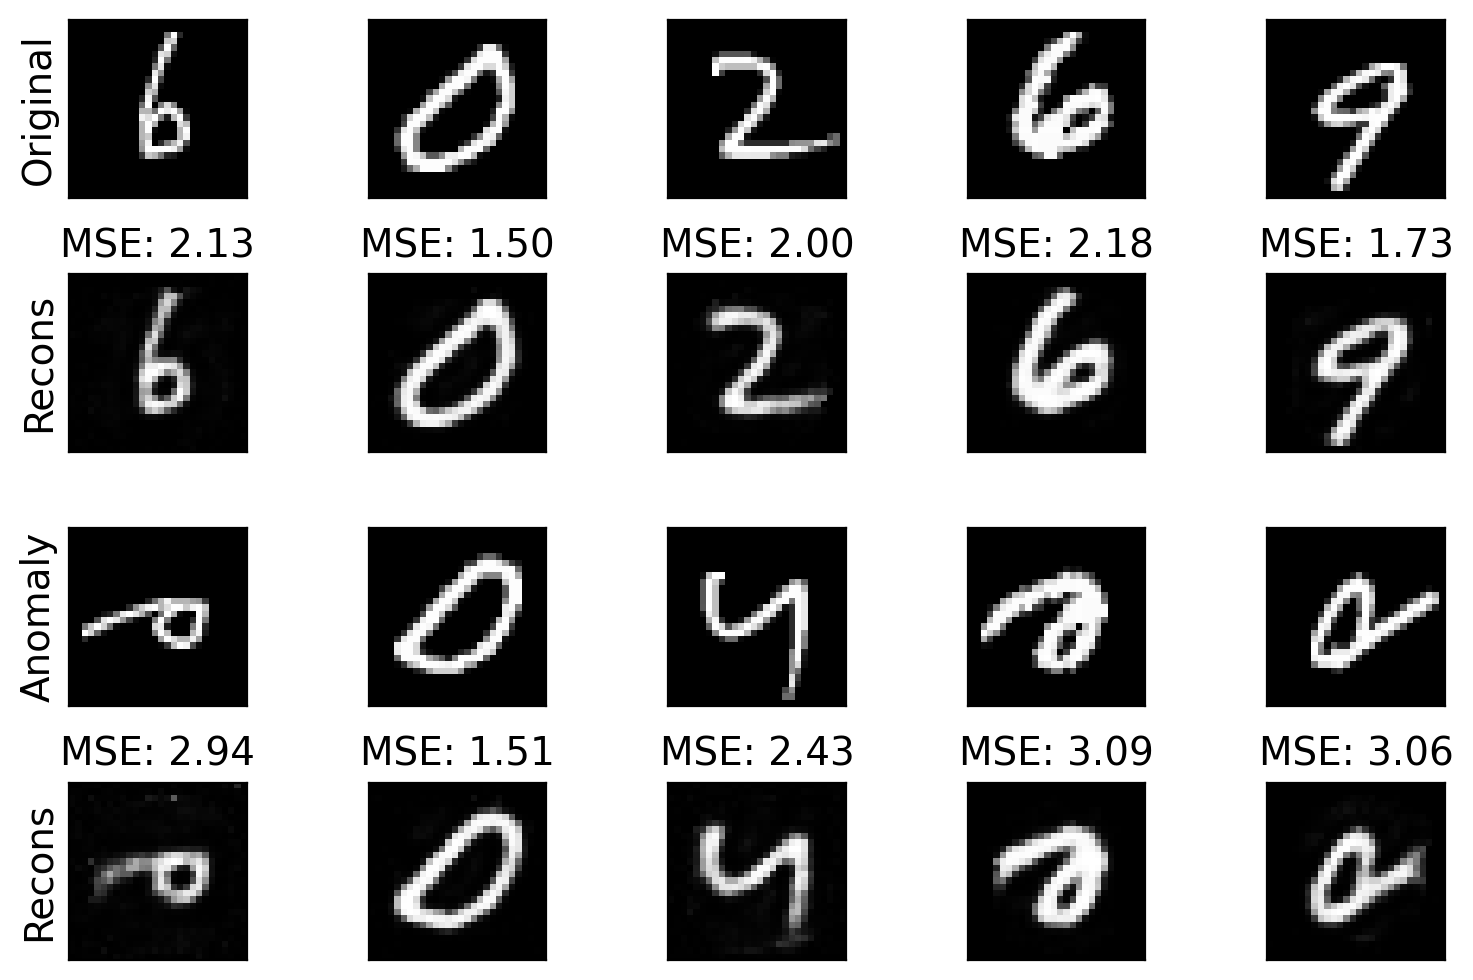

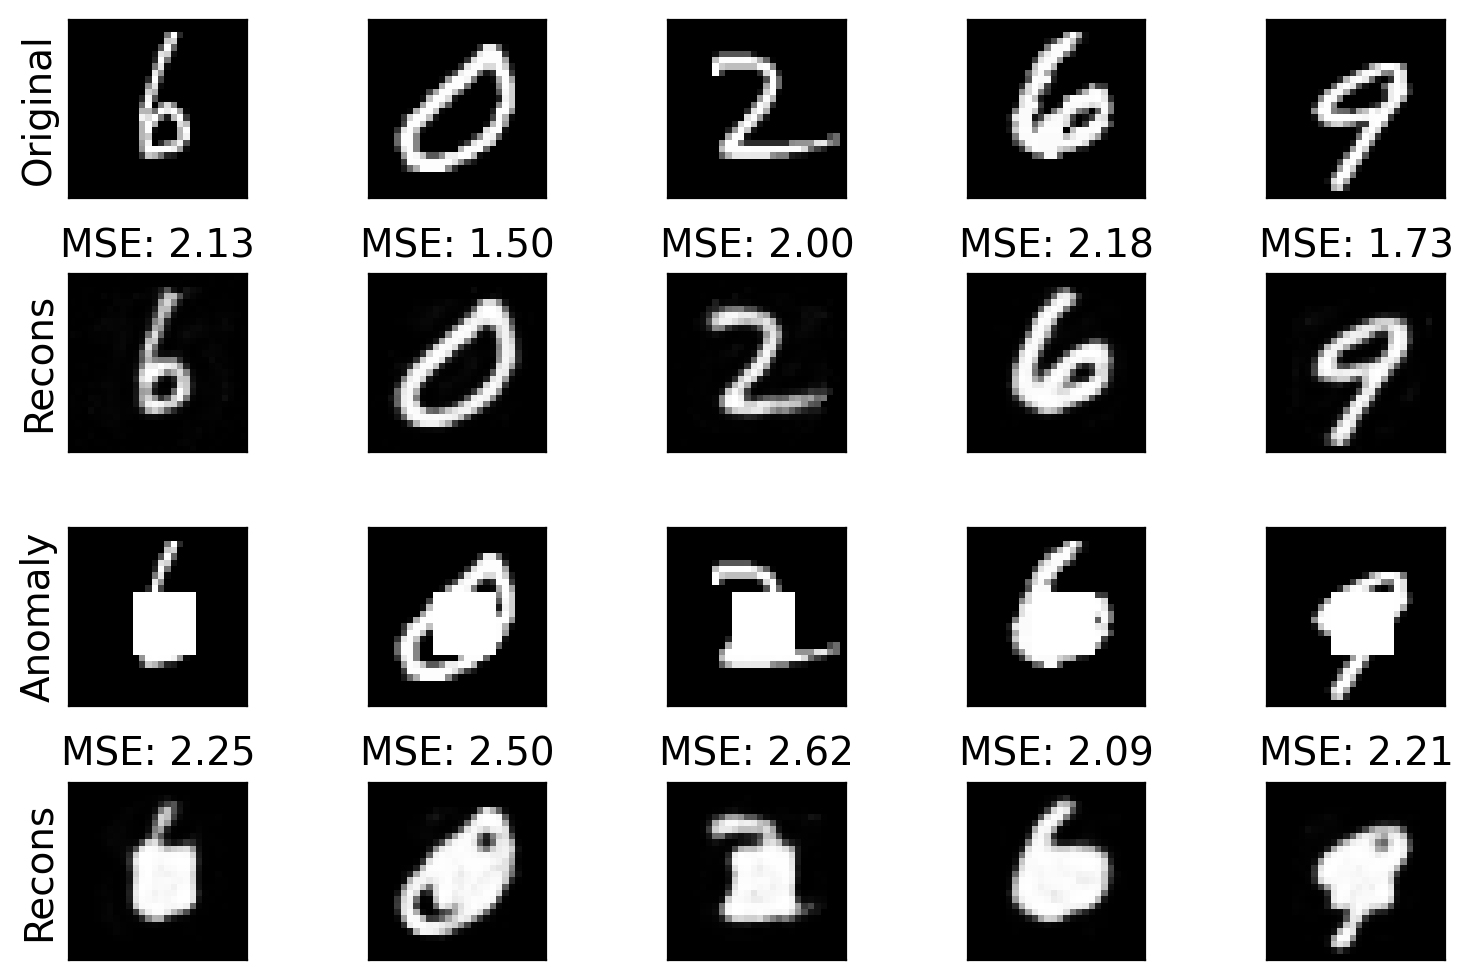

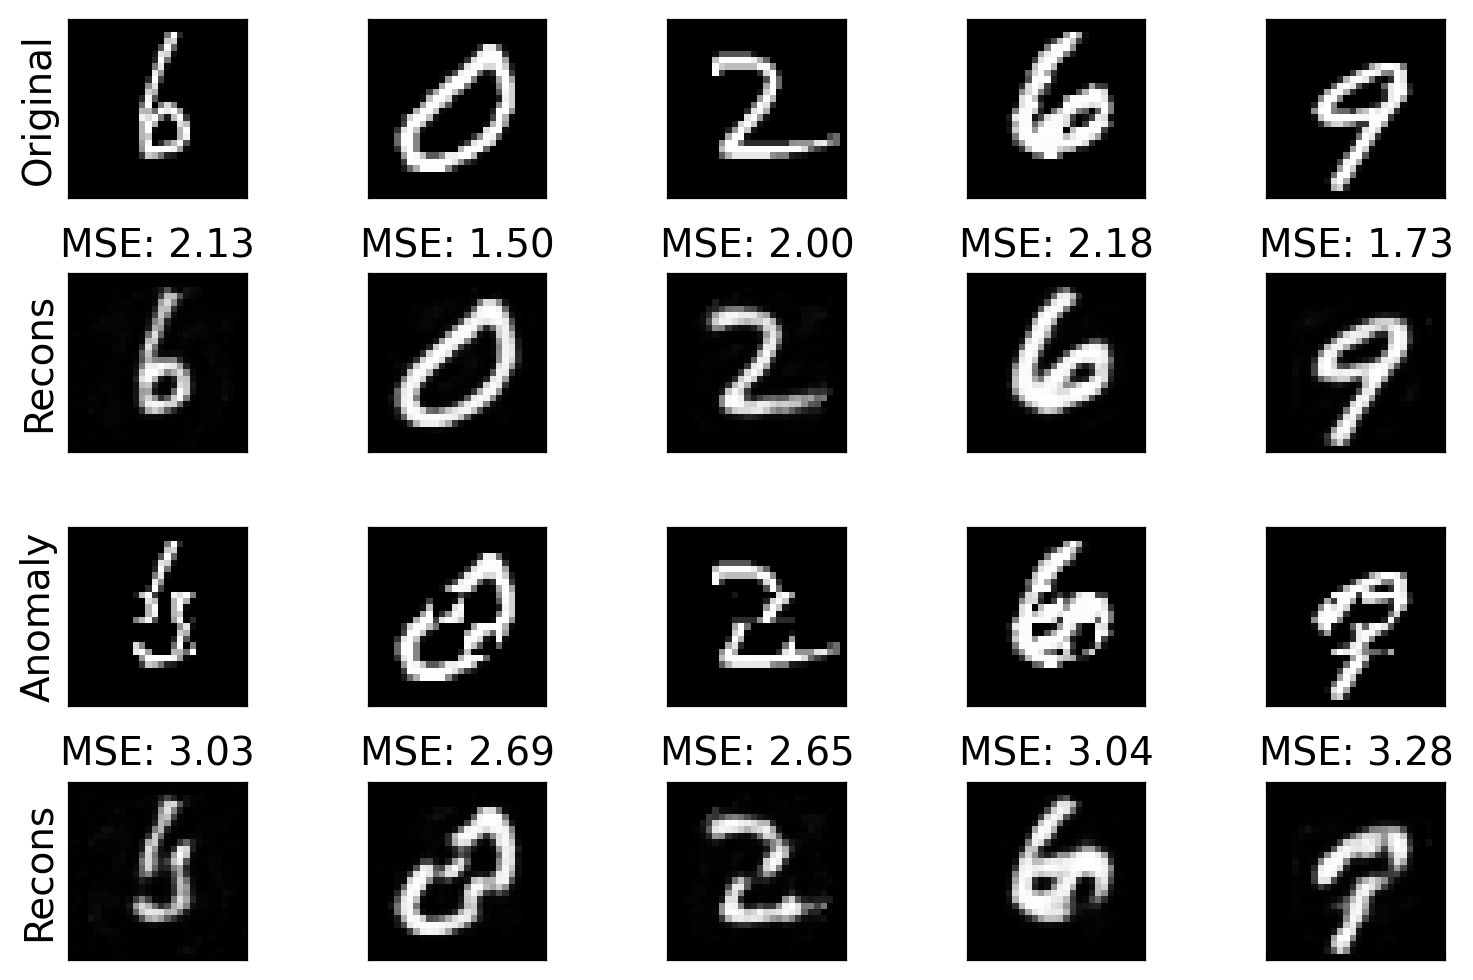

In [52]:
plot_anomalies(AE, mode='transpose')
plot_anomalies(AE, mode='artifacts')
plot_anomalies(AE, mode='mixing')

<font color='blue'>TODO:</font>
- code a function that compute these two histograms and plot these
- check if the histogram differs for the different type of anomalies

In [53]:

def detect_anomalies(model,loader, mode='transpose'):
    '''detect_anomalies
    Plot the histogram of the MSE of the anomalies on the test set
    Input:
    - model: the trained model
    - mode: the mode for the anomaly detection among ['transpose', 'artifacts', 'mixing']
    Output:
    - None
    '''
    mse = nn.MSELoss(reduction='none')
    mse_images = []
    mse_anomalies = []
    for images, _ in loader:
        images = images
        anomalies = make_anomaly(images, mode=mode)
        recons = model(images)
        recons_a = model(anomalies)
        mse_images.append(mse(recons,images).sum(dim=3).sum(dim=2).cpu().detach().numpy())
        mse_anomalies.append(mse(recons_a,anomalies).sum(dim=3).sum(dim=2).cpu().detach().numpy())
    
    plt.figure(figsize=(4, 4))
    mse_images = np.concatenate(mse_images)
    h1 = plt.hist(mse_images, bins=50, alpha=0.5, label='Images', density=True)
    mse_anomalies = np.concatenate(mse_anomalies)
    h2 = plt.hist(mse_anomalies, bins=50, alpha=0.5, label='Anomalies', density=True)
    plt.legend()
    plt.title(mode)
    plt.show()


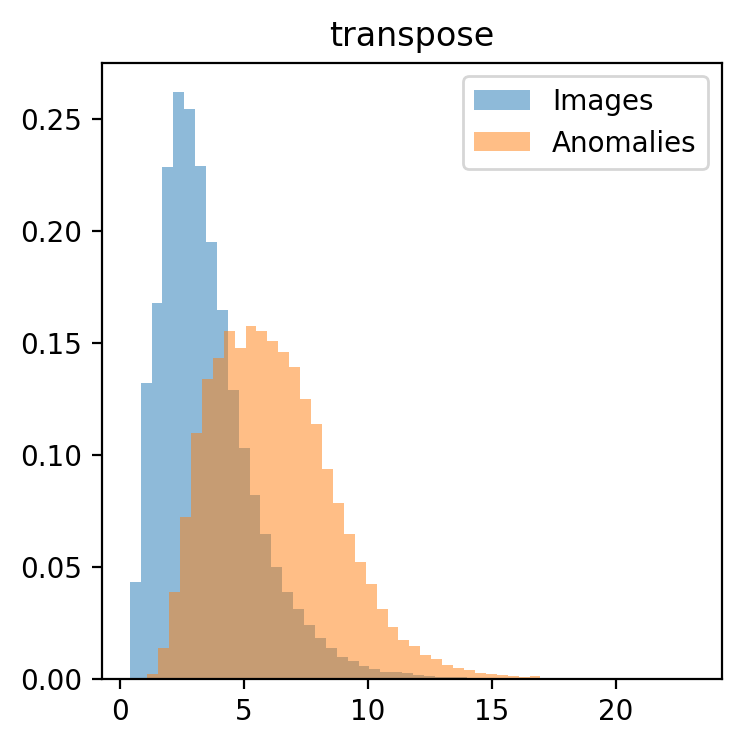

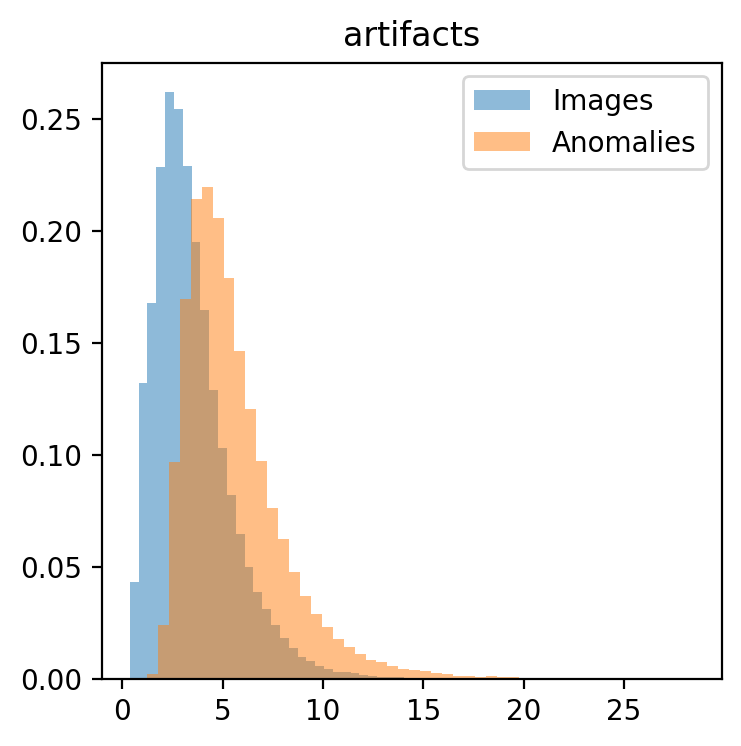

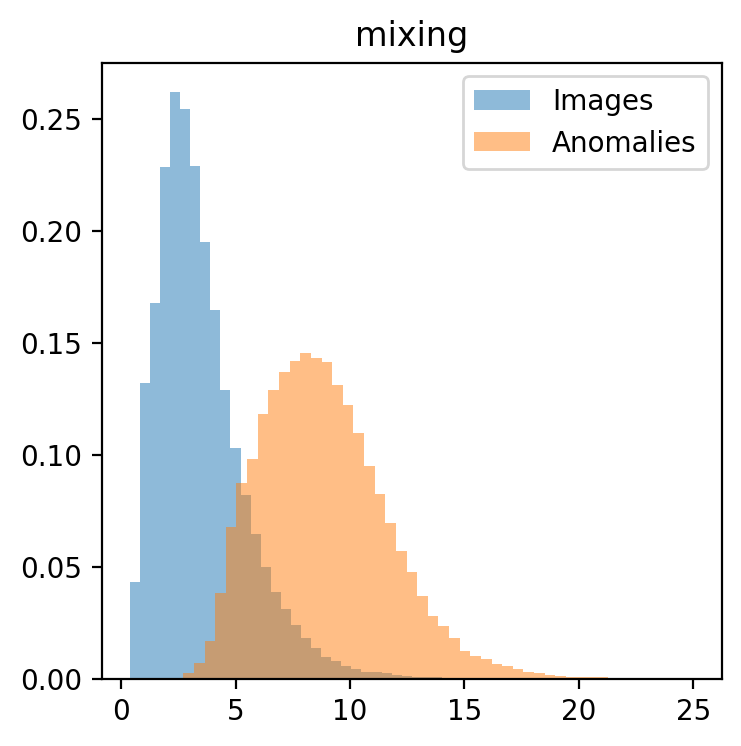

In [54]:
detect_anomalies(AE, train_loader, mode='transpose')
detect_anomalies(AE, train_loader, mode='artifacts')
detect_anomalies(AE, train_loader, mode='mixing')


# 6 Full connected autoencoder

We can increase the depth of the AE:
- the encoder is composed of a first linear transformation, followed by a non-linearity (ReLU) and a second linear transformation.
- the decoder performs the symmetric operations.

As dimensions we can consider as a first choice : 784 #  256 ==> $h_{dim}=2$ ==> 256 ==> 784.

<font color='blue'>TODO:</font>
- Write the class for such AE and test with the basic configuration (see above).
- Train the model for $h_{dim}=2$ and $h_{dim}=100$ and compare the results.

In [70]:
class SimpleAE(nn.Module):
    def __init__(self,hdim1=256,hdim2=2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, hdim1),
            nn.ReLU(),
            nn.Linear(hdim1, hdim2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(hdim2, hdim1),
            nn.ReLU(),
            nn.Linear(hdim1, 28*28),
            nn.Sigmoid()
        )
        
    def encoder_function(self, x):
        x = x.view(x.size(0), -1)
        return self.encoder(x)

    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.reshape(x.size(0), 1, 28, 28)
        return decoded

Start training...
Train Epoch: 0 [    0/60000 (  0%)]	Loss: 0.233187
Train Epoch: 0 [ 1000/60000 (  2%)]	Loss: 0.233240
Train Epoch: 0 [ 2000/60000 (  3%)]	Loss: 0.232188
Train Epoch: 0 [ 3000/60000 (  5%)]	Loss: 0.232909
Train Epoch: 0 [ 4000/60000 (  7%)]	Loss: 0.232804
Train Epoch: 0 [ 5000/60000 (  8%)]	Loss: 0.232377
Train Epoch: 0 [ 6000/60000 ( 10%)]	Loss: 0.232469
Train Epoch: 0 [ 7000/60000 ( 12%)]	Loss: 0.232745
Train Epoch: 0 [ 8000/60000 ( 13%)]	Loss: 0.232589
Train Epoch: 0 [ 9000/60000 ( 15%)]	Loss: 0.233566
Train Epoch: 0 [10000/60000 ( 17%)]	Loss: 0.232584
Train Epoch: 0 [11000/60000 ( 18%)]	Loss: 0.232630
Train Epoch: 0 [12000/60000 ( 20%)]	Loss: 0.232782
Train Epoch: 0 [13000/60000 ( 22%)]	Loss: 0.232652
Train Epoch: 0 [14000/60000 ( 23%)]	Loss: 0.233210
Train Epoch: 0 [15000/60000 ( 25%)]	Loss: 0.232515
Train Epoch: 0 [16000/60000 ( 27%)]	Loss: 0.233585
Train Epoch: 0 [17000/60000 ( 28%)]	Loss: 0.232650
Train Epoch: 0 [18000/60000 ( 30%)]	Loss: 0.233282
Train Epoch: 

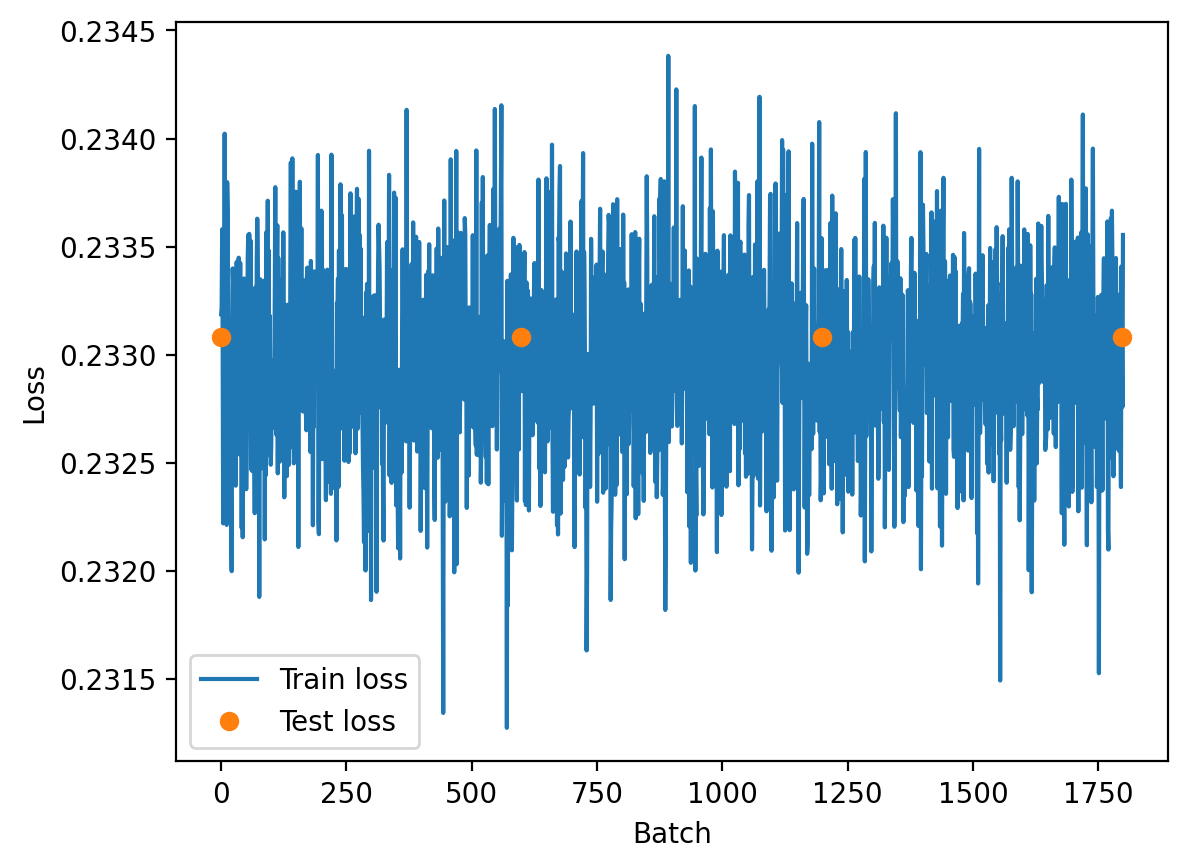

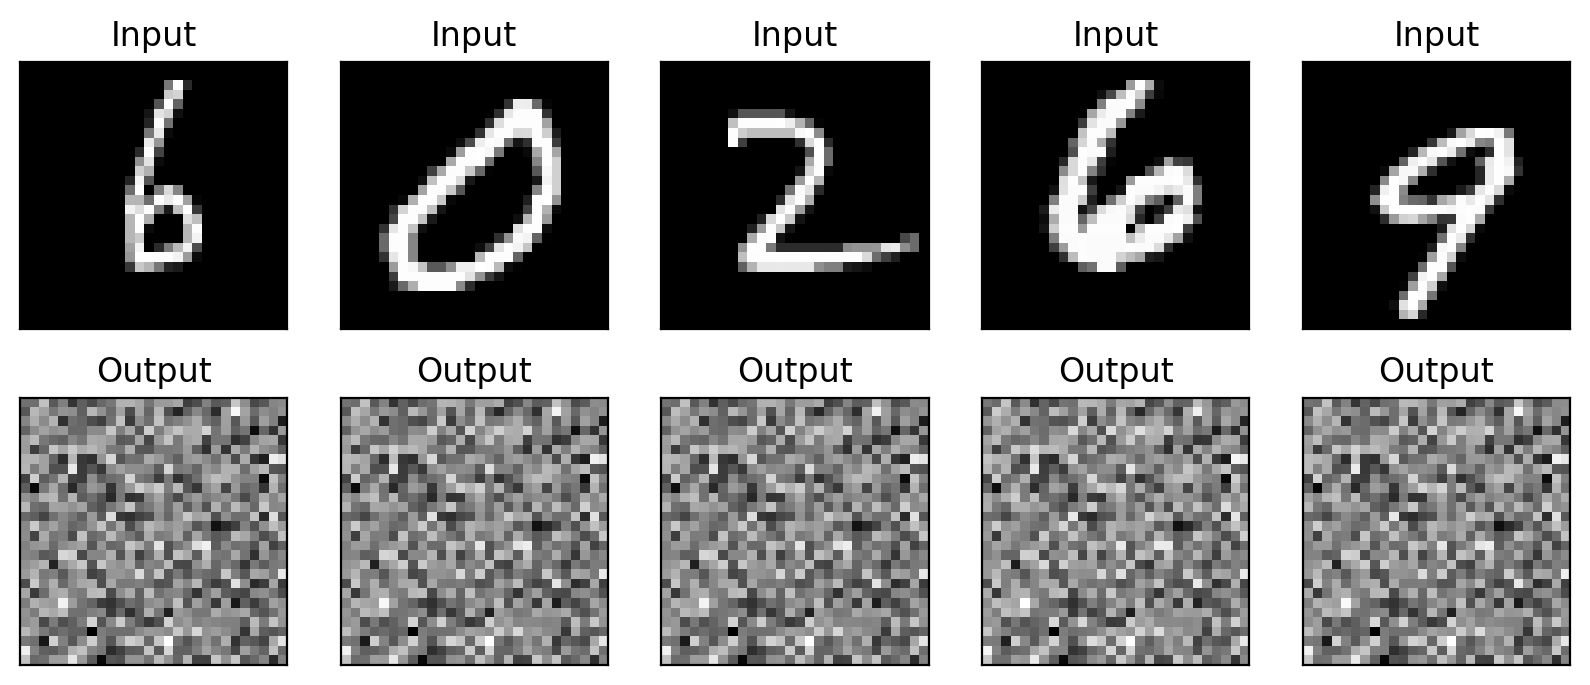

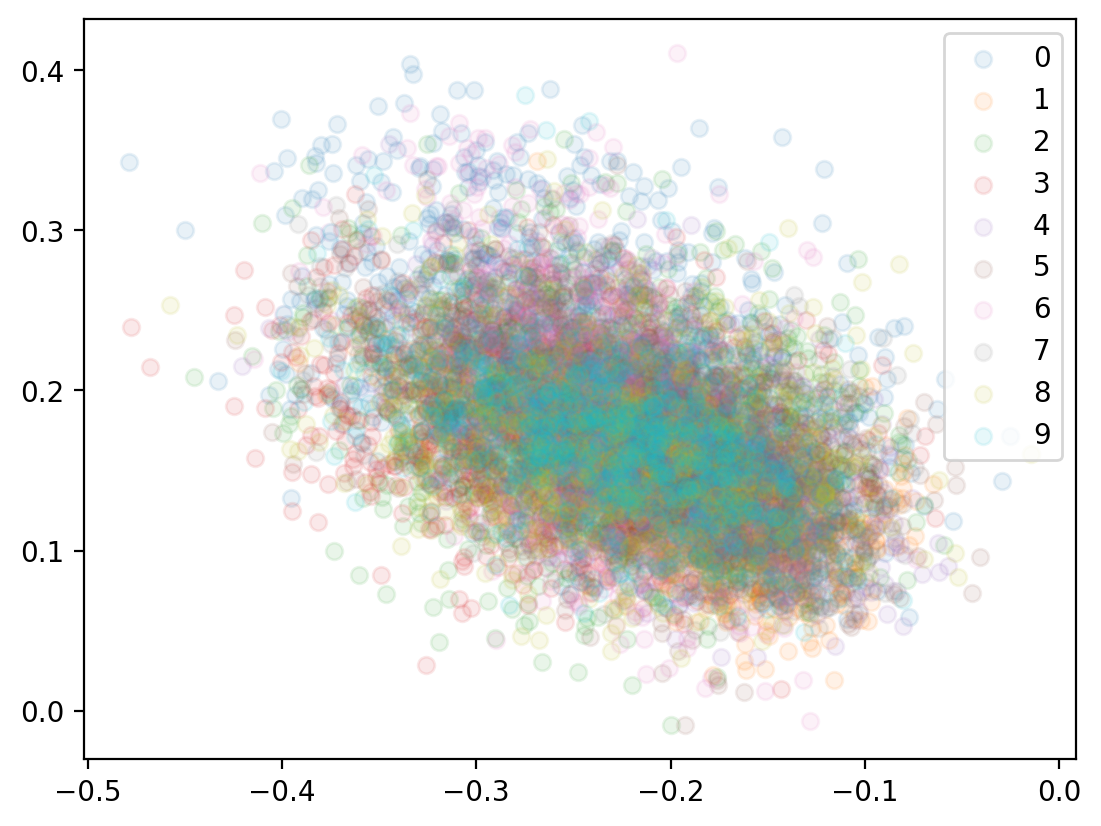

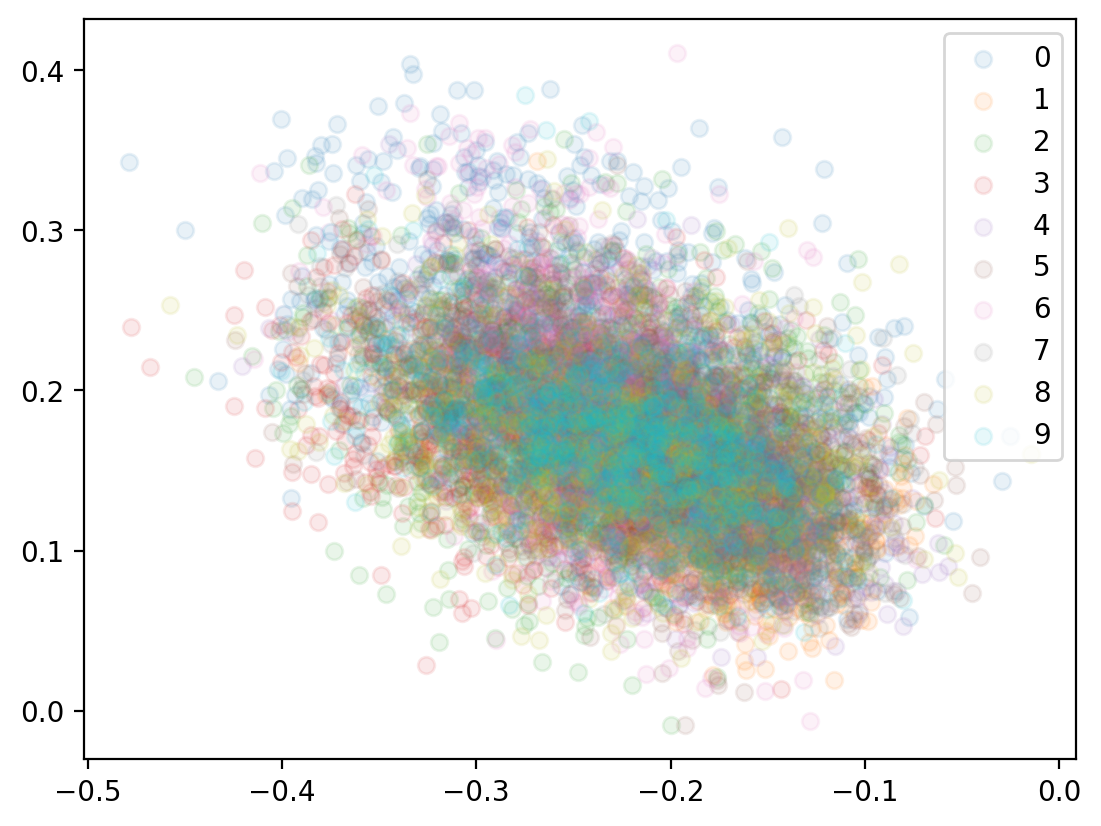

In [71]:
SAE = SimpleAE() # Complete code here
optimizer = optim.Adam(AE.parameters(), lr=1e-3) # Complete code here
AE_train(SAE, lossAE, optimizer, epochs=3, plot=True, verbose=True, freq=10); # Complete code here
plot_result(SAE)
plotLatentScatter(SAE.encoder_function, classes=[0,1,2,3,4,5,6,7,8,9])
plotLatentScatter(SAE.encoder_function, classes=[0,1,2,3,4,5,6,7,8,9])

In [ ]:
SAE = ... # Complete code here
optimizer = ... # Complete code here
_ = AE_train( ... ) # Complete code here
plot_result(SAE)

<font color='blue'>TODO:</font>
- Test the denoising and anomaly detection.

In [ ]:
plot_anomalies(SAE, mode='transpose')
plot_anomalies(SAE, mode='artifacts')
plot_anomalies(SAE, mode='mixing')

In [ ]:
detect_anomalies(SAE, train_loader, mode='transpose')
detect_anomalies(SAE, train_loader, mode='artifacts')
detect_anomalies(SAE, train_loader, mode='mixing')


# 7 Convolutional Autoencoder

**TODO**:
Implement a CNN Autoencoder with the following architecture:
- Encoder:
    - Conv2d(1, 16, kernel_size=3, stride=2, padding=1) ==> ReLU ==> Conv2d(16, 32, kernel_size=3, stride=2, padding=1) ==> ReLU ==> Flatten ==> Linear(1568, $h_{dim}$)
- Decoder:
    - Linear($h_{dim}$, 1568) ==> ReLu ==> Unflatten ==> ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1) ==> ReLU ==> ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1) ==> Sigmoid

In [63]:
class ConvAE(nn.Module):
    def __init__(self, hdim=2):
        super().__init__()
        input_shape = (1,28,28)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # 16x14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # 32x7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32*7*7, hdim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(hdim, 32*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (32,7,7)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=1, padding=1), # 16x14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, output_padding=1, padding=1), # 1x28x28
            nn.Sigmoid()
        )        

    def encoder_function(self, x):
        return self.encoder(x)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Number of parameters: 17411


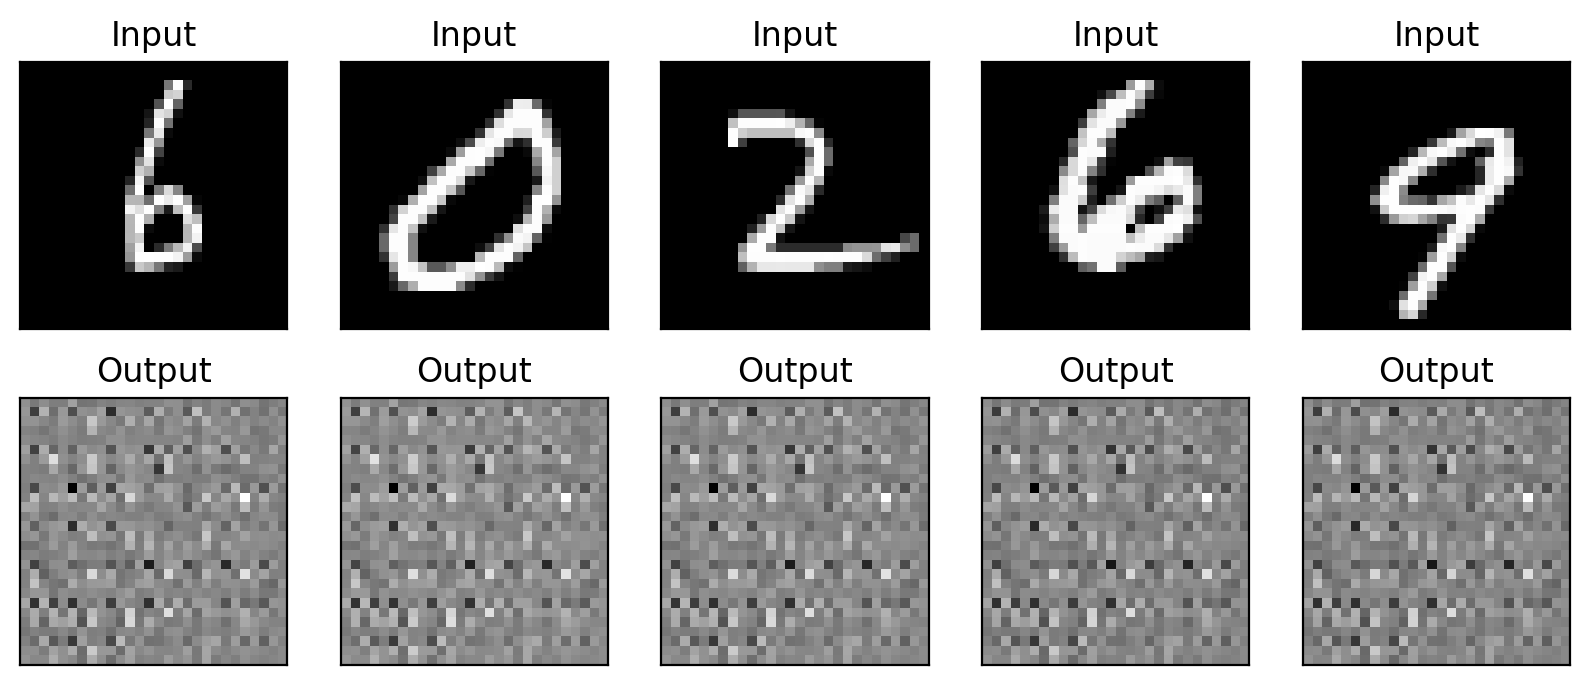

In [64]:
CAE = ConvAE()
print_nparameters(CAE)
plot_result(CAE)


<font color='blue'>TODO:</font>
- Train the model for $h_{dim}=2$ and $h_{dim}=20$ and compare the results.

Start training...
Train Epoch: 0 [    0/60000 (  0%)]	Loss: 0.264008
Train Epoch: 0 [10000/60000 ( 17%)]	Loss: 0.078011
Train Epoch: 0 [20000/60000 ( 33%)]	Loss: 0.062963
Train Epoch: 0 [30000/60000 ( 50%)]	Loss: 0.059023
Train Epoch: 0 [40000/60000 ( 67%)]	Loss: 0.057741
Train Epoch: 0 [50000/60000 ( 83%)]	Loss: 0.056113
Train Epoch: 0 [59900/60000 (100%)]	Loss: 0.056269
Train Epoch: 1 [    0/60000 (  0%)]	Loss: 0.060668
Train Epoch: 1 [10000/60000 ( 17%)]	Loss: 0.054368
Train Epoch: 1 [20000/60000 ( 33%)]	Loss: 0.055325
Train Epoch: 1 [30000/60000 ( 50%)]	Loss: 0.055693
Train Epoch: 1 [40000/60000 ( 67%)]	Loss: 0.052315
Train Epoch: 1 [50000/60000 ( 83%)]	Loss: 0.056132
Train Epoch: 1 [59900/60000 (100%)]	Loss: 0.054478
Train Epoch: 2 [    0/60000 (  0%)]	Loss: 0.055281
Train Epoch: 2 [10000/60000 ( 17%)]	Loss: 0.052080
Train Epoch: 2 [20000/60000 ( 33%)]	Loss: 0.052049
Train Epoch: 2 [30000/60000 ( 50%)]	Loss: 0.053487
Train Epoch: 2 [40000/60000 ( 67%)]	Loss: 0.054696
Train Epoch: 

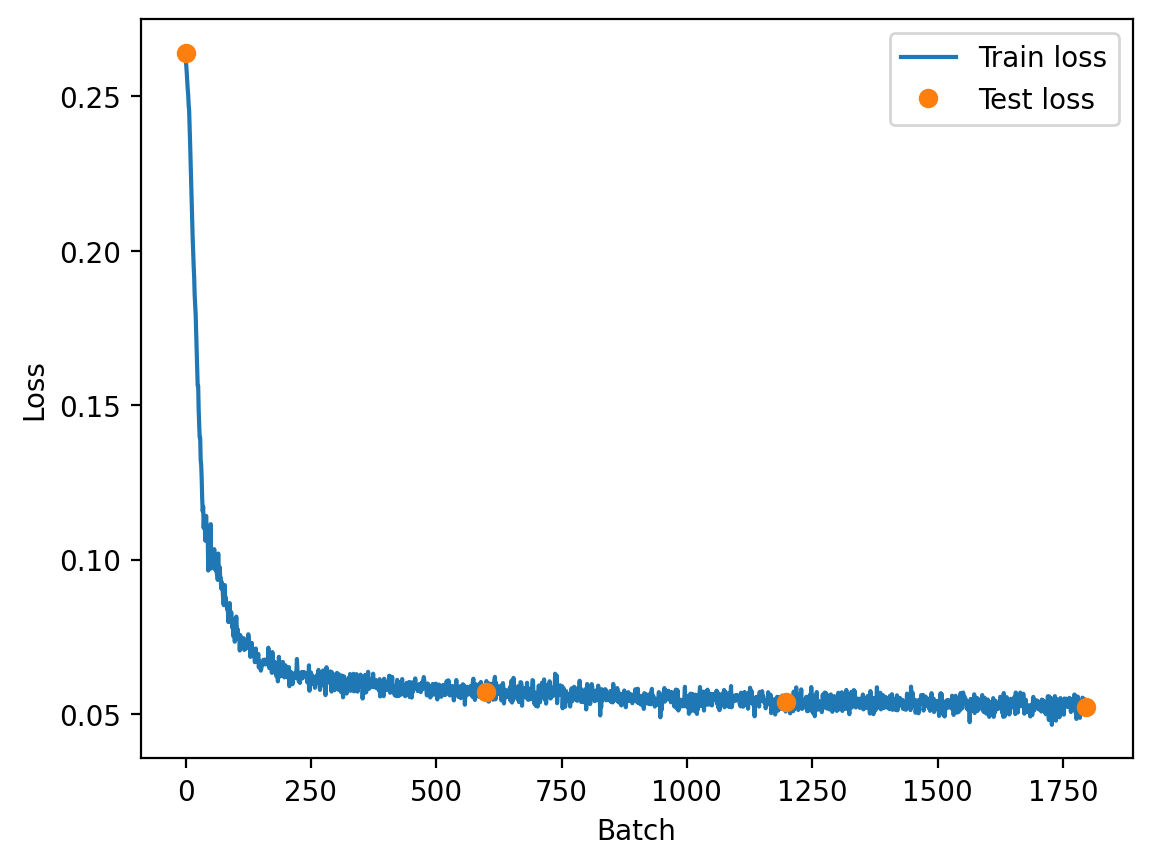

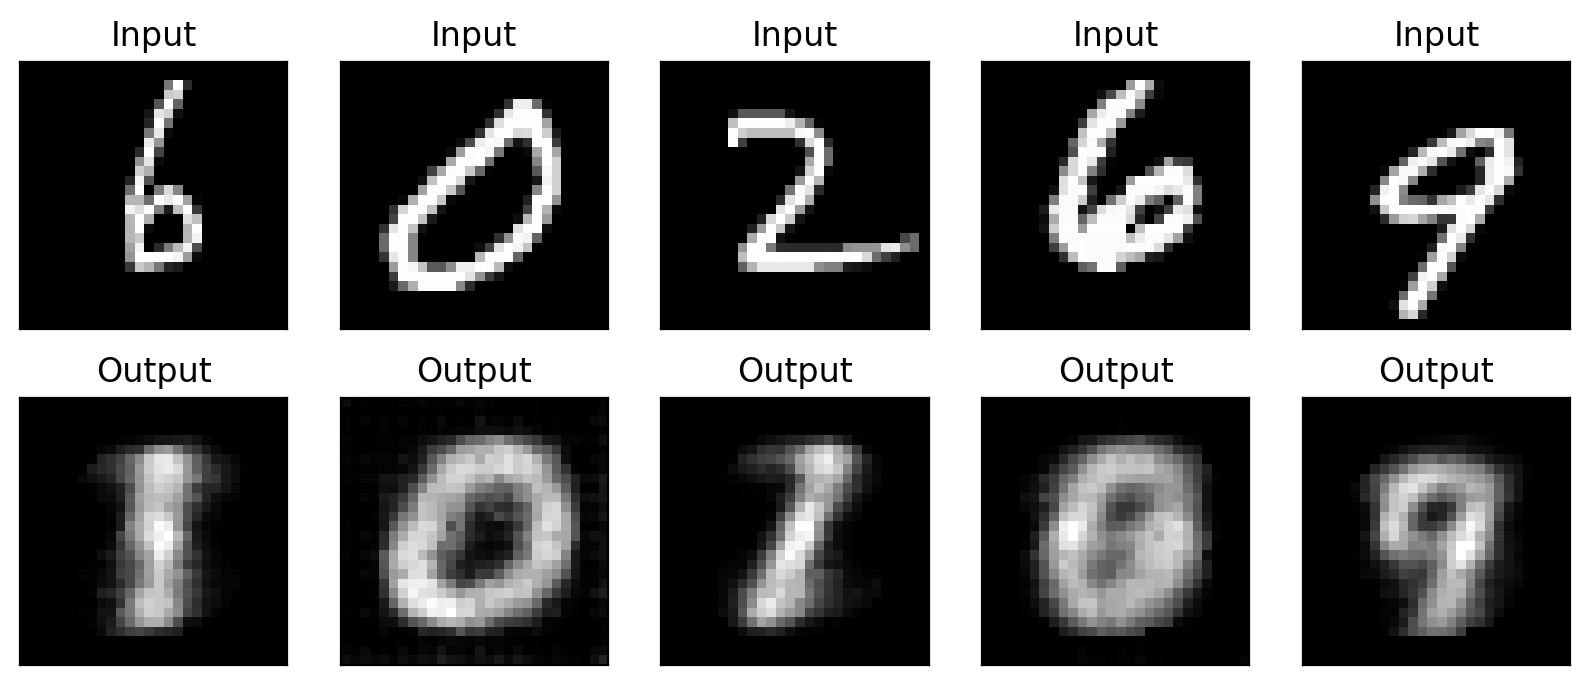

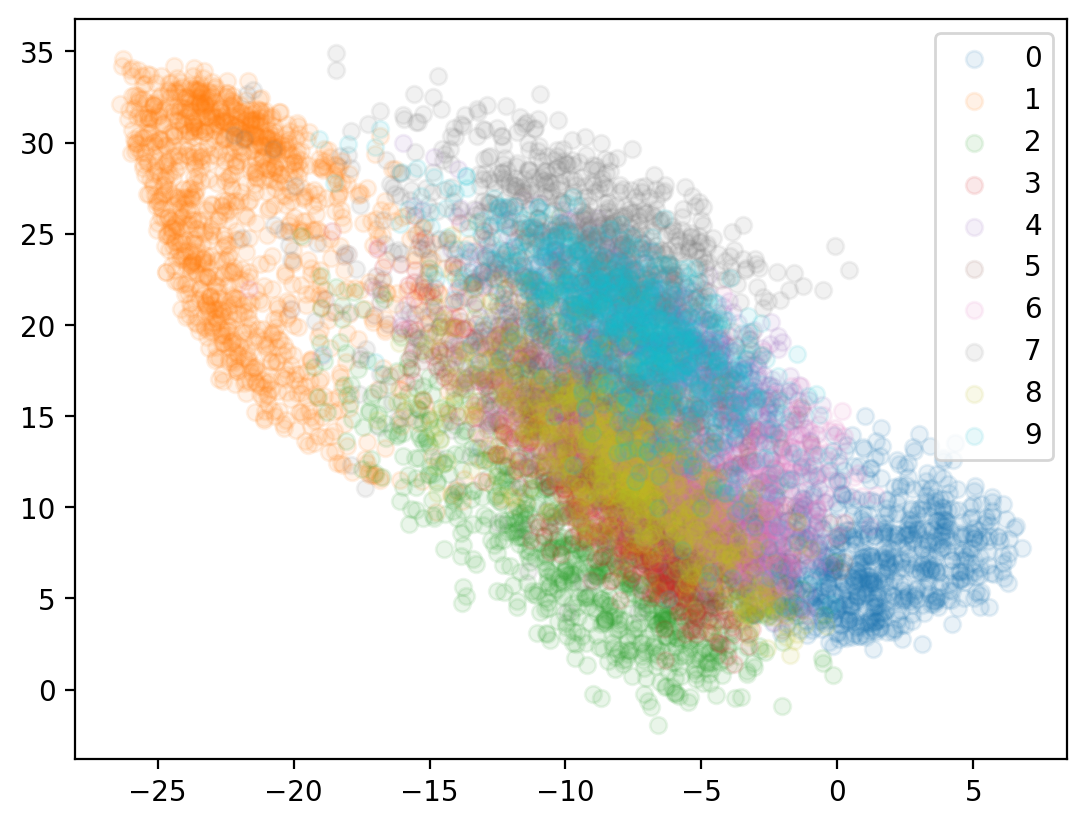

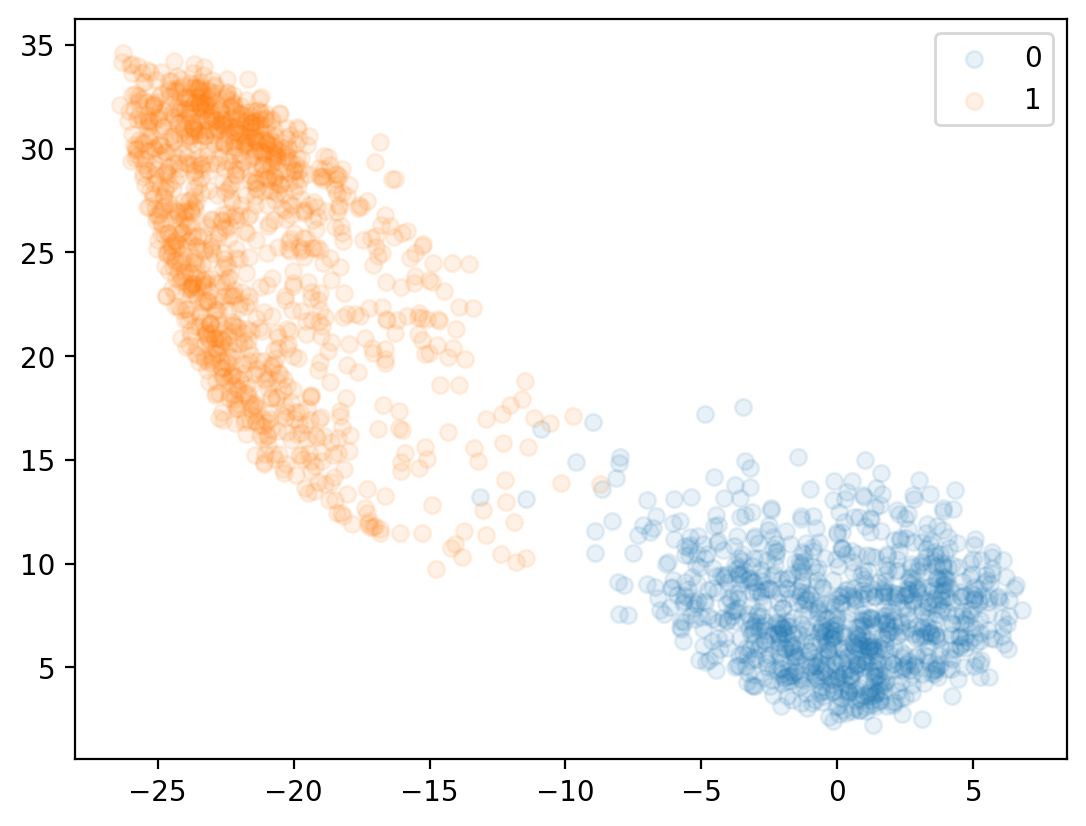

NameError: name 'plot_denoising' is not defined

In [65]:
CAE = ConvAE()
optimizer = optim.Adam(CAE.parameters(), lr=1e-3)
_ = AE_train(CAE, lossAE, optimizer, epochs=3, plot=True, verbose=True, freq=100)
plot_result(CAE)
plotLatentScatter(CAE.encoder_function, classes=[0,1,2,3,4,5,6,7,8,9])
plotLatentScatter(CAE.encoder_function, classes=[0,1])
#plot_denoising(CAE)
plot_anomalies(CAE, mode='transpose')
plot_anomalies(CAE, mode='artifacts')
plot_anomalies(CAE, mode='mixing')

Start training...
Train Epoch: 0 [    0/60000 (  0%)]	Loss: 0.230555
Train Epoch: 0 [10000/60000 ( 17%)]	Loss: 0.068967
Train Epoch: 0 [20000/60000 ( 33%)]	Loss: 0.058135
Train Epoch: 0 [30000/60000 ( 50%)]	Loss: 0.030047
Train Epoch: 0 [40000/60000 ( 67%)]	Loss: 0.021829
Train Epoch: 0 [50000/60000 ( 83%)]	Loss: 0.018410
Train Epoch: 0 [59900/60000 (100%)]	Loss: 0.017645
Train Epoch: 1 [    0/60000 (  0%)]	Loss: 0.016207
Train Epoch: 1 [10000/60000 ( 17%)]	Loss: 0.015898
Train Epoch: 1 [20000/60000 ( 33%)]	Loss: 0.015548
Train Epoch: 1 [30000/60000 ( 50%)]	Loss: 0.013803
Train Epoch: 1 [40000/60000 ( 67%)]	Loss: 0.014033
Train Epoch: 1 [50000/60000 ( 83%)]	Loss: 0.013541
Train Epoch: 1 [59900/60000 (100%)]	Loss: 0.012201
Train Epoch: 2 [    0/60000 (  0%)]	Loss: 0.010959
Train Epoch: 2 [10000/60000 ( 17%)]	Loss: 0.012287
Train Epoch: 2 [20000/60000 ( 33%)]	Loss: 0.013172
Train Epoch: 2 [30000/60000 ( 50%)]	Loss: 0.011942
Train Epoch: 2 [40000/60000 ( 67%)]	Loss: 0.011076
Train Epoch: 

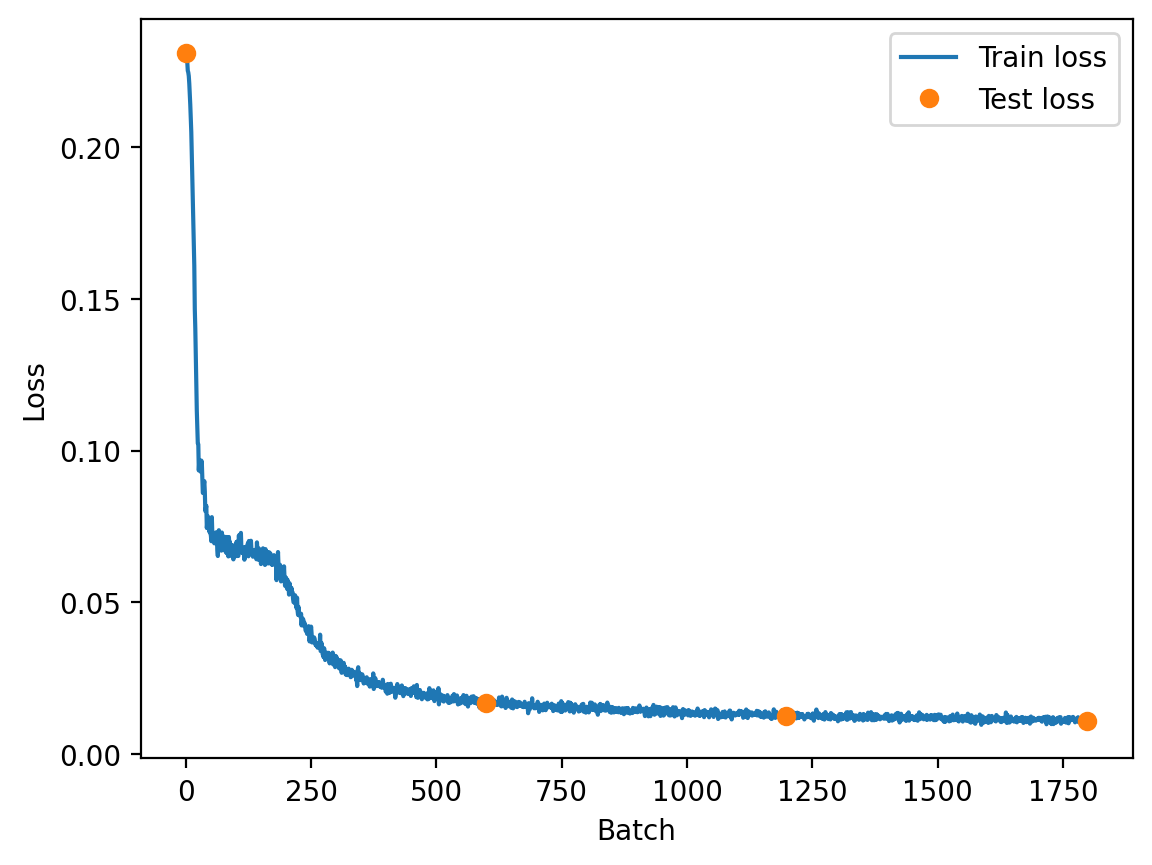

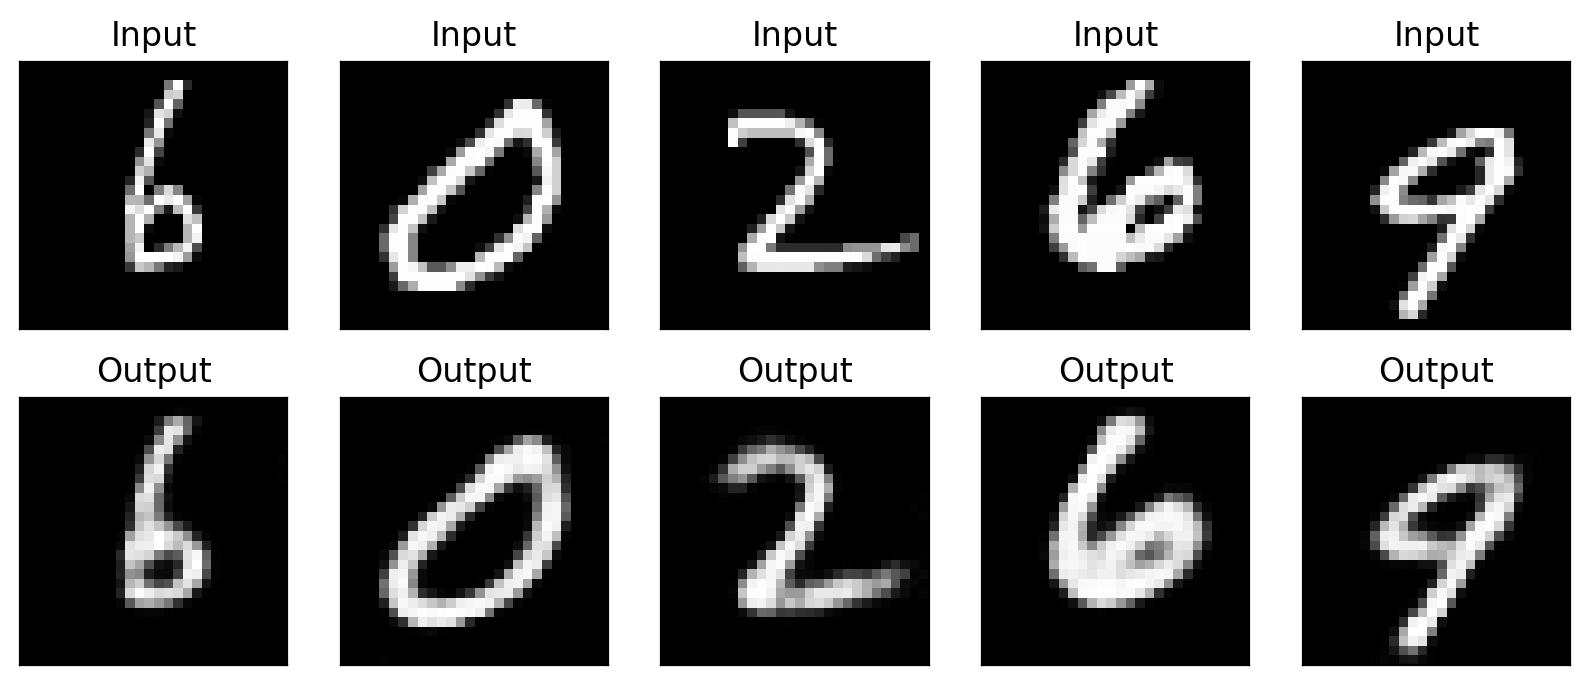

In [66]:
CAE = ConvAE(20)
optimizer = optim.Adam(CAE.parameters(), lr=1e-3)
_ = AE_train(CAE, lossAE, optimizer, epochs=3, plot=True, verbose=True, freq=100)
plot_result(CAE)

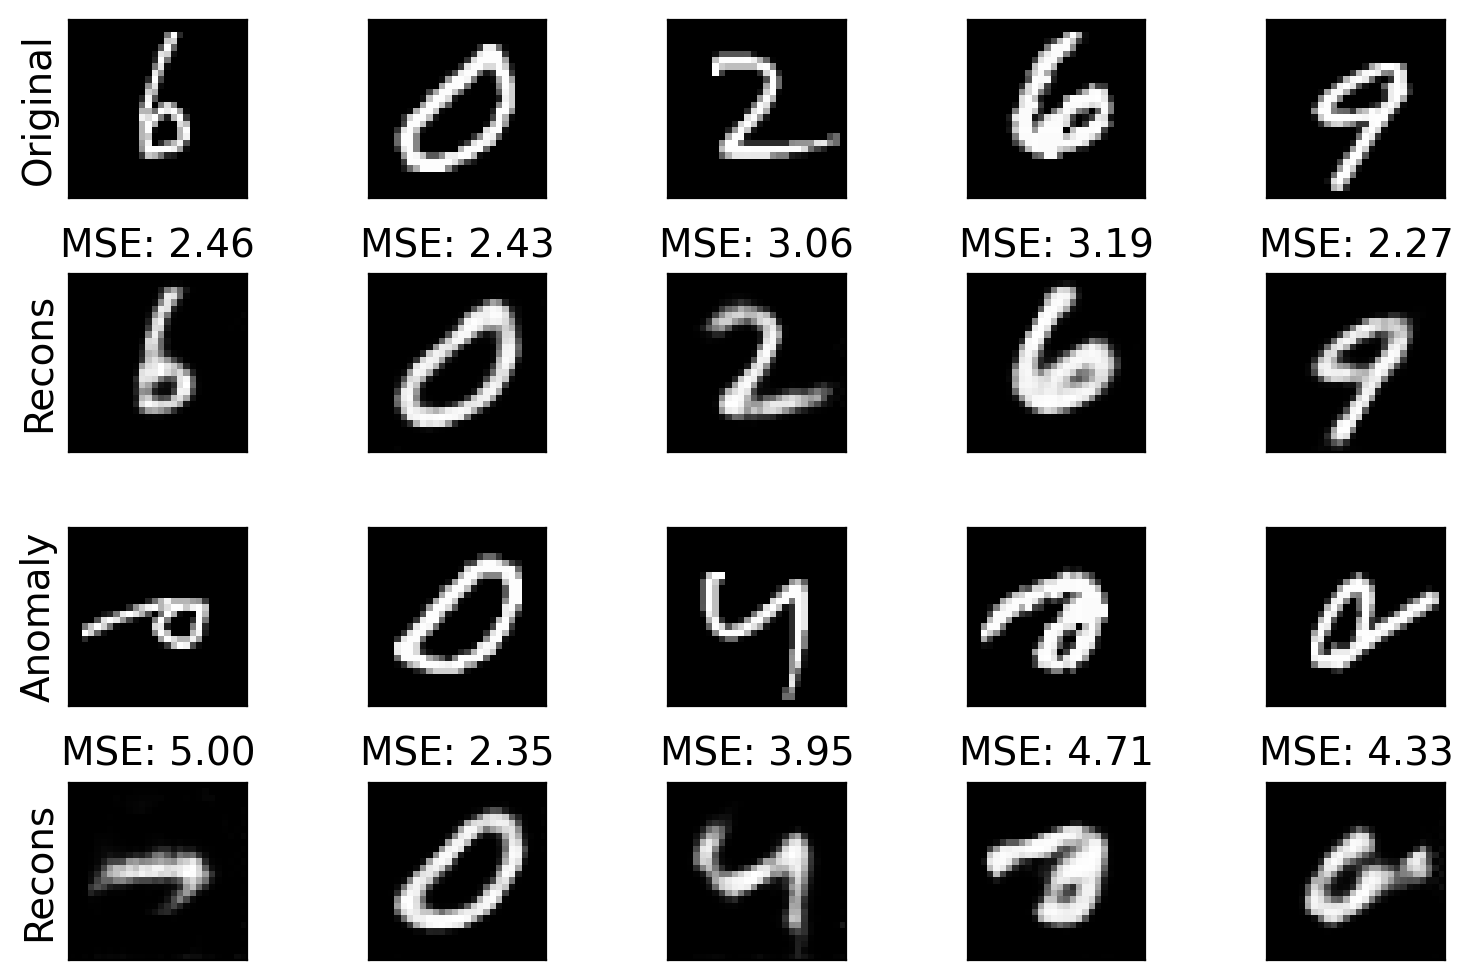

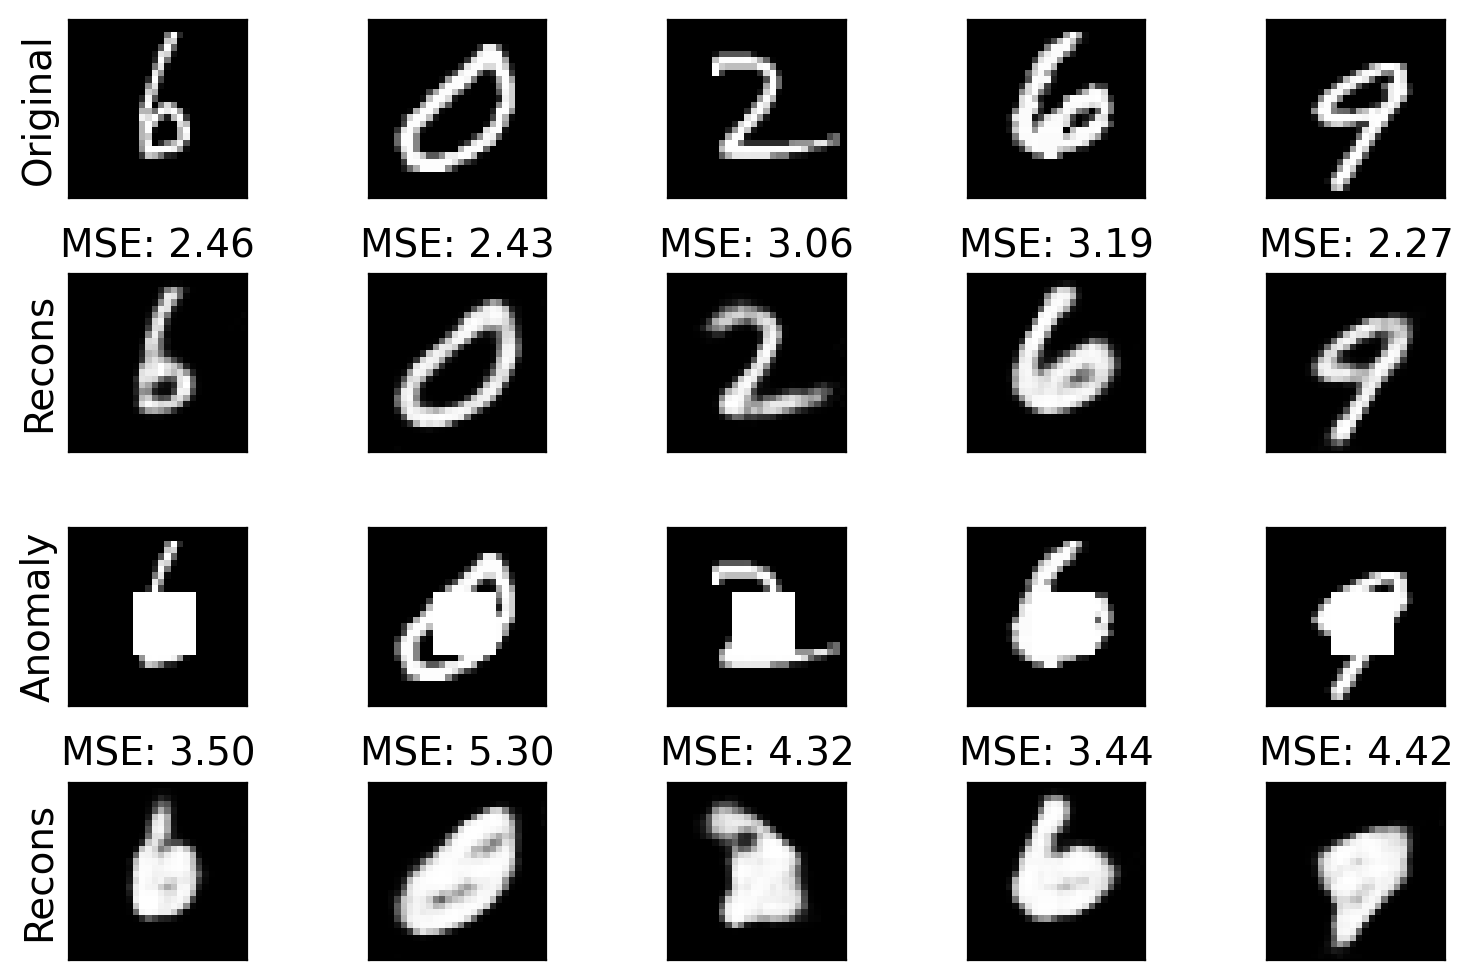

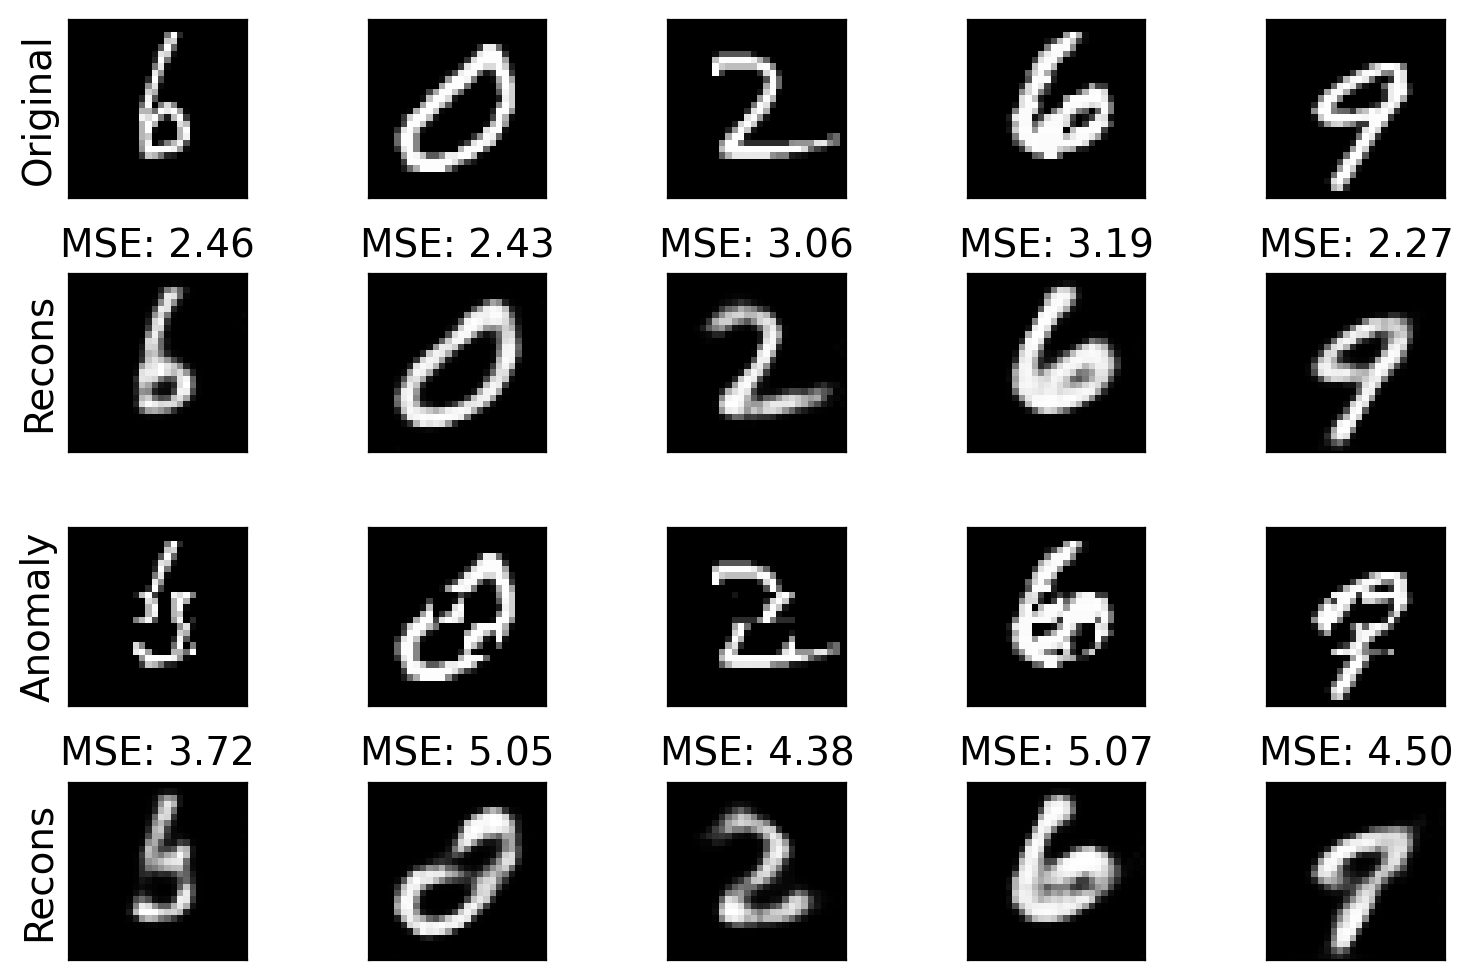

In [67]:
#plot_denoising(CAE)
plot_anomalies(CAE, mode='transpose')
plot_anomalies(CAE, mode='artifacts')
plot_anomalies(CAE, mode='mixing')

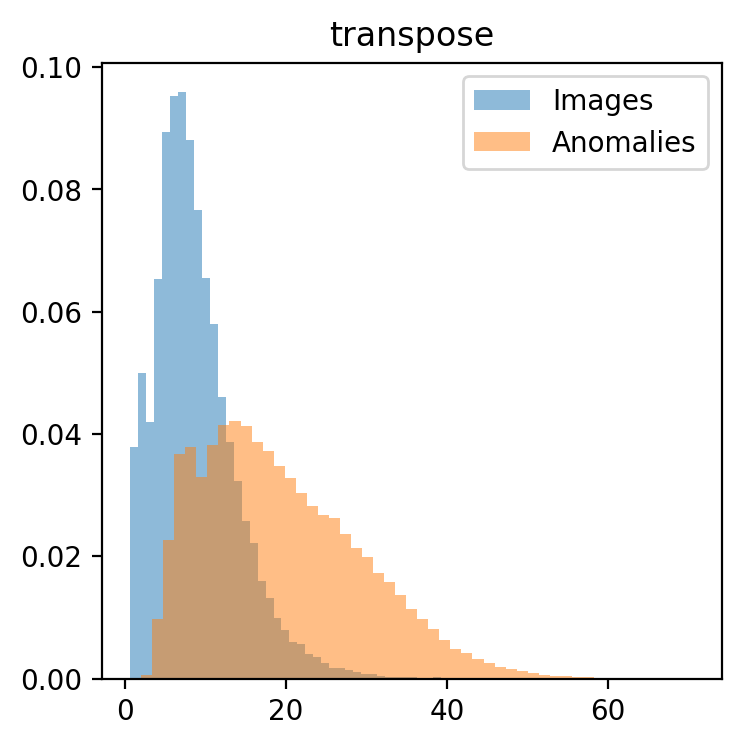

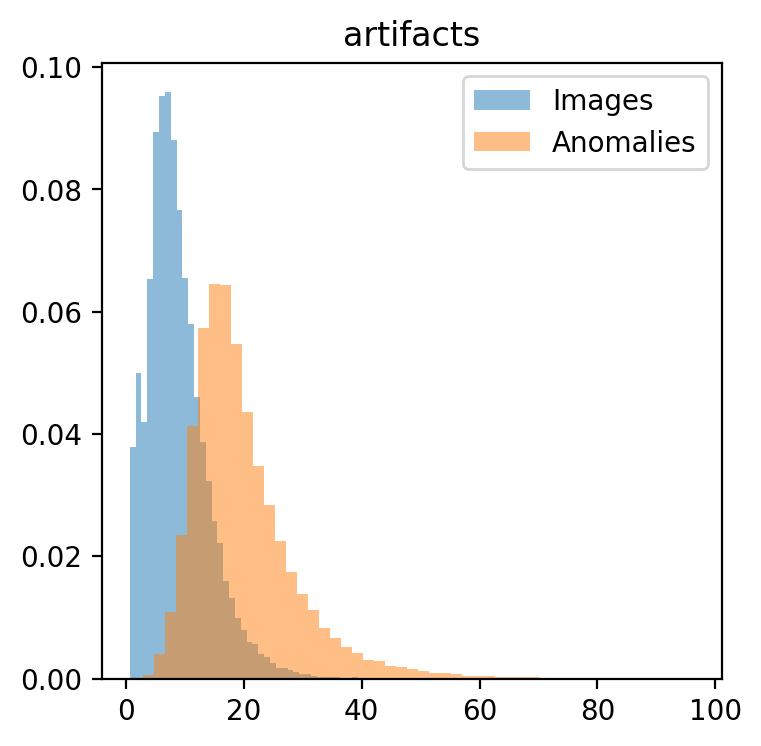

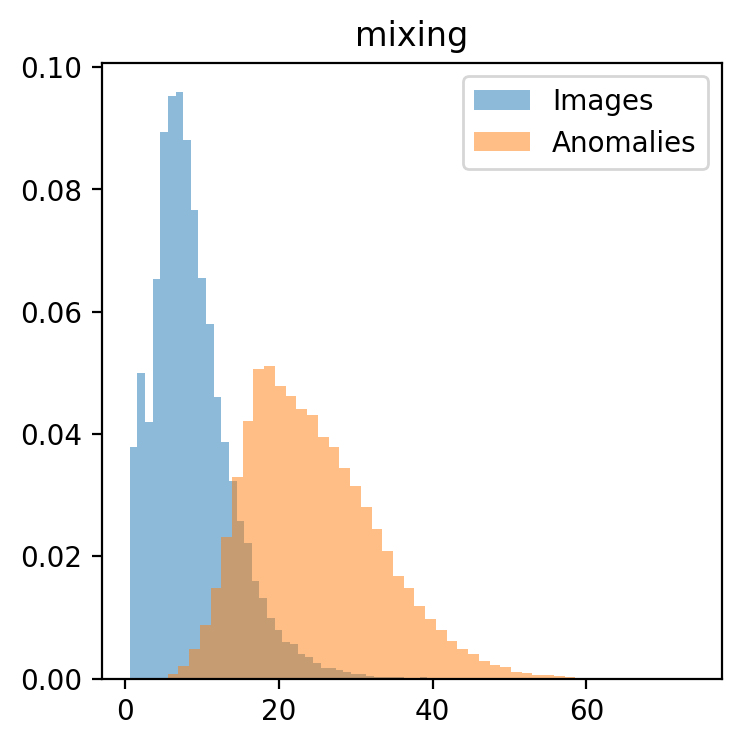

In [68]:
detect_anomalies(CAE, train_loader, mode='transpose')
detect_anomalies(CAE, train_loader, mode='artifacts')
detect_anomalies(CAE, train_loader, mode='mixing')